## Apprentissage par Transfert du CNN en utilisant VGG-16 Mis à Jour
Ce notebook a été mis à jour pour intégrer les chemins et la gestion des données du notebook SIFT, assurant une approche cohérente dans la gestion du jeu de données.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


## Chargement et Prétraitement des Données  
Ici, nous chargeons et prétraitons nos données d'images, en nous alignant sur les méthodes utilisées dans le notebook SIFT."

In [2]:
import pandas as pd
import os

# Define relative path
file_path = os.path.join("..", "data", "flipkart_com-ecommerce_sample_1050.csv")

# Load the CSV in a DataFrame
df = pd.read_csv(file_path)

# first lignes of the df
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

### Import du dataset des images sous forme de fichiers jpg


Image: 009099b1f6e1e8f893ec29a7023153c4.jpg
 - Dimensions: (687, 1162)
 - Mode: RGB
------------------------------
Image: 0096e89cc25a8b96fb9808716406fe94.jpg
 - Dimensions: (1478, 904)
 - Mode: RGB
------------------------------
Image: 00cbbc837d340fa163d11e169fbdb952.jpg
 - Dimensions: (1347, 326)
 - Mode: RGB
------------------------------
Image: 00d84a518e0550612fcfcba3b02b6255.jpg
 - Dimensions: (1100, 857)
 - Mode: RGB
------------------------------
Image: 00e966a5049a262cfc72e6bbf68b80e7.jpg
 - Dimensions: (962, 1100)
 - Mode: RGB
------------------------------
Image: 00ed03657cedbe4663eff2d7fa702a33.jpg
 - Dimensions: (788, 2430)
 - Mode: RGB
------------------------------


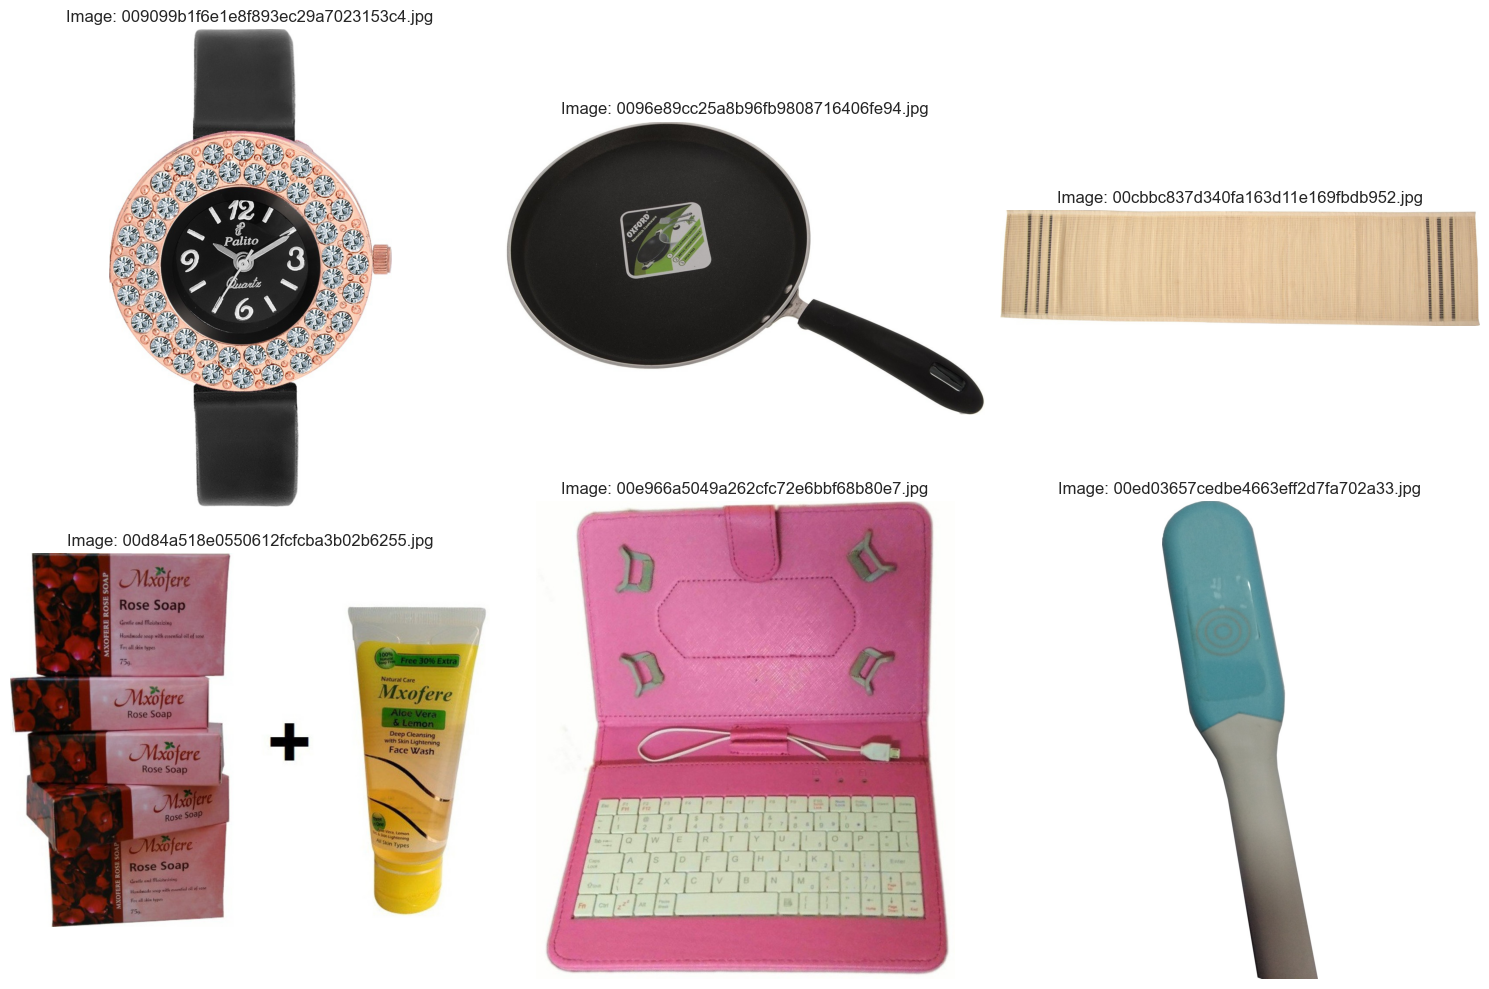

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the folder containing the images
images_folder = os.path.join("..", "data", "Images")

# List all files in the folder
image_files = os.listdir(images_folder)

# Select the first 6 images
selected_images = image_files[:6]

# Set up the figure to display 6 images (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Load and display information about each image
for i, image_name in enumerate(selected_images):
    image_path = os.path.join(images_folder, image_name)
    image = Image.open(image_path)
    
    # Display information about the image
    print(f"Image: {image_name}")
    print(f" - Dimensions: {image.size}")
    print(f" - Mode: {image.mode}")
    print("-" * 30)
    
    # Display the image in the grid
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(f"Image: {image_name}")
    ax.axis('off')  # Turn off the axes for better presentation

# Display the grid
plt.tight_layout()
plt.show()



In [4]:

import pandas as pd

# Load the data into a DataFrame
df = pd.read_csv('../data/flipkart_com-ecommerce_sample_1050.csv')

# Display the unique values in the 'product_category_tree' column
print(df['product_category_tree'].unique())

# Extract the first category from the 'product_category_tree' column
df['category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].strip())
# Put category in lowercase
df['category'] = df['category'].apply(lambda x: x.lower())
# Display the unique values in the 'category' column
print(df['category'].unique())


['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'
 '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'
 '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]'
 '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]'
 '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]'
 '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]'
 '["Watches >> Wrist Watches >> Camerii Wrist Watches"]'
 '["Watches >> Wrist Watches >> T STAR Wrist Watches"]'
 '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]'
 '["Watches >> Wrist Watches >> TAG Heuer Wrist Watches"]'
 '["Watches >> Wrist Watches >> Calibro Wri

### Recuperation de la première catégorie de produits

In [5]:
# Display the unique values in the 'product_category_tree' column
df['product_category_tree'].unique()

array(['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]',
       '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]',
       '["Watches >> Wrist Watches >> Camerii Wrist Watches"]',
       '["Watches >> Wrist Watches >> T STAR Wrist Watches"]',
       '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]',
       '["Watches >> Wrist Watches >> T

In [6]:
# Extract the first category from the 'product_category_tree' column
df['category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0][2:-1])
# Put category in lowercase and in a list
df['category'] = df['category'].apply(lambda x: x.lower())
# Display the unique values in the 'category' column
df['category'].unique()

array(['home furnishing', 'baby care', 'watches',
       'home decor & festive needs', 'kitchen & dining',
       'beauty and personal care', 'computers'], dtype=object)

In [7]:
# Display the first few rows of the DataFrame
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications         category  
0  {"product_specification"=>[{"key"=>"Brand", "v...  home furnishing  
1  {"product_specification"=>[{"key"=>"Machine Wa...        baby care  
2  {"product_specification"=>[{"key"=>"Material",...        baby care  
3  {"product_specification"=>[{"key"=>"Brand", "v...  home furnishing  
4  {"product_specification"=>[{"key"=>"Machine Wa...  home furnishing

# Creation du dataframe pour le traitement des images

In [8]:
# Create a new DataFrame with the 'image' and 'category' columns
df_images = df.copy()
df_images = df_images[['image', 'category']]
df_images.head()

image         category
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  home furnishing
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        baby care
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        baby care
3  d4684dcdc759dd9cdf41504698d737d8.jpg  home furnishing
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  home furnishing

### Création colonne label dans le DataFrame

In [9]:
from sklearn import preprocessing

# Initialize the label encoder
le = preprocessing.LabelEncoder()

# Fit the label encoder to the 'category' column
le.fit(df_images['category'])

# Transform the 'category' column to create a new 'label' column
df_images['label'] = le.transform(df_images['category'])

# Create a mapping from category labels to numeric labels
category_to_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Display the mapping
print("Category to Label Mapping:")
print(category_to_label_mapping)

# Display the updated DataFrame with the new 'label' column
df_images.head(6)


Category to Label Mapping:
{'baby care': 0, 'beauty and personal care': 1, 'computers': 2, 'home decor & festive needs': 3, 'home furnishing': 4, 'kitchen & dining': 5, 'watches': 6}


image         category  label
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  home furnishing      4
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        baby care      0
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        baby care      0
3  d4684dcdc759dd9cdf41504698d737d8.jpg  home furnishing      4
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  home furnishing      4
5  893aa5ed55f7cff2eccea7758d7a86bd.jpg          watches      6

In [10]:
df_images.groupby("label").count()

image  category
label                 
0        150       150
1        150       150
2        150       150
3        150       150
4        150       150
5        150       150
6        150       150

In [11]:
print(df_images.columns)


Index(['image', 'category', 'label'], dtype='object')


baby care


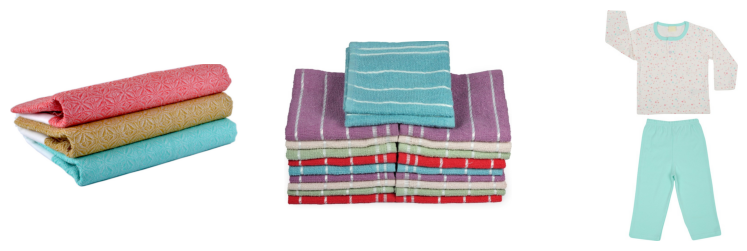

beauty and personal care


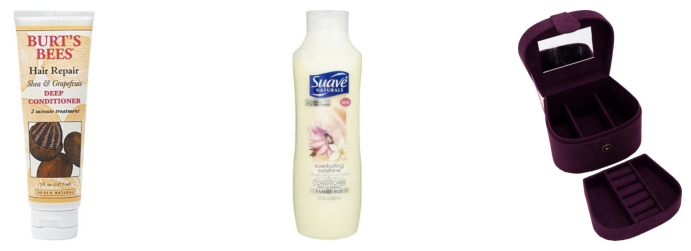

computers


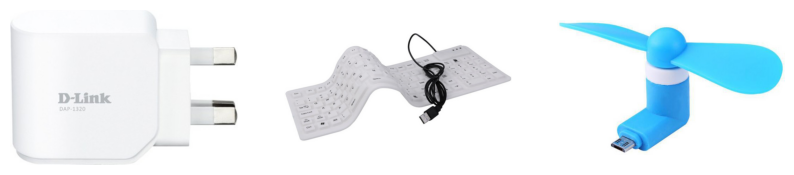

home decor & festive needs


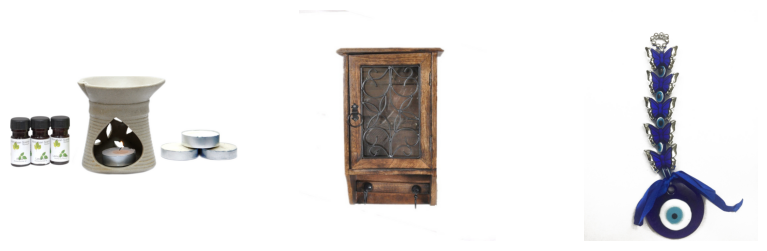

home furnishing


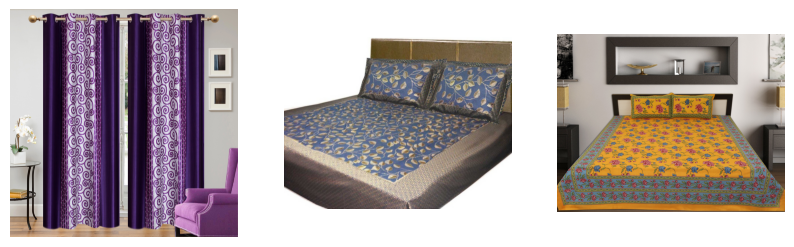

kitchen & dining


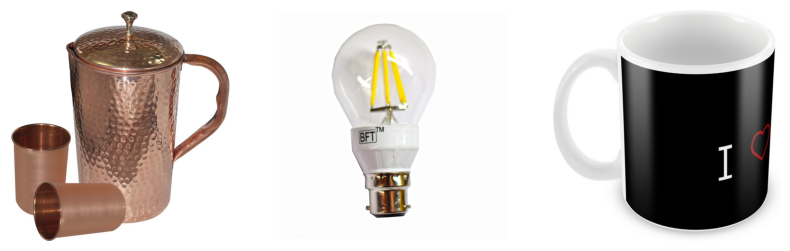

watches


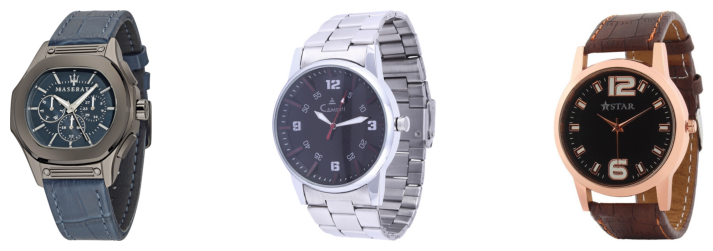

In [12]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os

# Updated category-to-label mapping based on your mapping
category_to_label_mapping = {
    'baby care': 0, 
    'beauty and personal care': 1, 
    'computers': 2, 
    'home decor & festive needs': 3, 
    'home furnishing': 4, 
    'kitchen & dining': 5, 
    'watches': 6
}

# Function to return a list of image paths based on textual category
def list_images_by_category(df, category):
    label = category_to_label_mapping[category]
    return df[df['label'] == label]['image'].tolist()

# Display three images for each category
for category in category_to_label_mapping.keys():
    print(category)
    image_list = list_images_by_category(df_images, category)
    plt.figure(figsize=(10, 3))  # Adjust the size of the figure for better visibility
    for i in range(min(3, len(image_list))):  # Display up to 3 images, or fewer if not available
        plt.subplot(1, 3, i + 1)  # Configuration for a row of 3 images
        filename = os.path.join(images_folder, image_list[i])  # Ensure that images_folder is correctly defined
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')  # Turn off the axes for better visibility
    plt.show()



# Etape 1 : étude de faisabilité

## Configuration du Modèle  
Configurer le modèle CNN en utilisant VGG-16, adapté aux exigences spécifiques du projet.

In [13]:
# this line initializes the VGG16 model with weights trained on the ImageNet dataset. By default, it includes the top fully connected layers.
base_model = VGG16() 

# This line creates a new model that uses the same inputs as the VGG16 model but only outputs from the second-to-last layer of the VGG16. This is often done to use the model as a feature extractor in transfer learning scenarios, where the convolutional base of the model is used to extract features that are then used to train a new classifier.
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output) # layers[-2] is the second-to-last layer of the model, a dense layer before the final classification layer.

# This line prints a summary of the model architecture, showing the layers and the number of parameters in each layer.
print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


### Observations :
1. **Configuration des couches :**
   - Le modèle inclut plusieurs couches convolutionnelles (`Conv2D`) et des couches de pooling (`MaxPooling2D`), typiques de l'architecture VGG.
   - Le nombre de filtres de convolution commence à 64 et double dans les couches plus profondes, atteignant 512 dans les derniers blocs.
   - Chaque bloc de convolution est suivi d'une couche de pooling qui réduit les dimensions spatiales de la sortie.

2. **Dimensions de sortie :**
   - Chaque couche de convolution conserve la profondeur mais modifie les dimensions spatiales en raison des strides dans les convolutions et le pooling.
   - Le dernier bloc réduit les dimensions spatiales à 7x7 tout en conservant 512 canaux.

3. **Aplatissement et couches denses :**
   - La sortie du dernier bloc de convolution est aplatie en un vecteur 1D, ce qui est courant avant de l'alimenter dans des couches totalement connectées (Dense).
   - Il y a deux couches denses de 4096 unités chacune, suivies de fonctions d'activation (supposées être ReLU, bien que non spécifiées dans le résumé).

4. **Taille du modèle :**
   - Le modèle a un total de 134,260,544 paramètres, ce qui indique un réseau très profond avec une capacité substantielle à apprendre à partir de jeux de données grands et complexes.
   - Tous les paramètres sont entraînables, comme indiqué par l'absence de paramètres non entraînables.

### Considérations pour votre projet :
- **Intensité des ressources :** VGG16 est un modèle large et computationnellement intensif. Assurez-vous de disposer des ressources matérielles suffisantes (de préférence un GPU) pour l'entraînement et l'inférence.
- **Extraction de caractéristiques :** Si vous utilisez le modèle VGG16 principalement pour l'extraction de caractéristiques, envisagez de geler les couches convolutionnelles et de n'entraîner que les couches denses supérieures. Cela peut être plus efficace car la base convolutionnelle a déjà appris des caractéristiques robustes à partir du jeu de données ImageNet.
- **Personnalisation pour des tâches spécifiques :** Comme votre projet implique la classification d'images en catégories spécifiques, vous pourriez remplacer la ou les couches supérieures pour correspondre au nombre de vos classes cibles.



### Extraction des features des images

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array # Import functions to load and preprocess images
from tensorflow.keras.applications.vgg16 import preprocess_input # Import function to preprocess images for VGG16
import numpy as np # Import NumPy library
import os
from PIL import Image # Import Python Imaging Library (PIL) to open and manipulate images

# Ensure PIL does not throw a DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = None  # This removes the limit entirely, use with caution

images_features = [] # Initialize an empty list to store the features
i = 0 # Initialize a counter to track the progress

# Make sure 'df_images' is your DataFrame and it contains a column 'image' with image filenames
for image_file in df_images['image']:
    if i % 100 == 0: # if i is a multiple of 100
        print(f'Processing image {i}')  # Print progress every 100 images
    i += 1 # Increment the counter
    image_path = os.path.join(images_folder, image_file)  # Build the full path to the image, e.g. 'data/Images/image.jpg'
    
    # Load and resize the image
    image = load_img(image_path, target_size=(224, 224)) # Load the image and resize to 224x224 pixels
    image = img_to_array(image)  # Convert the image to a numpy array for processing
    image = np.expand_dims(image, axis=0)  # Add a dimension to create a batch of size 1, e.g. (1, 224, 224, 3), 1 is the batch size, 224x224 is the image size, and 3 is the number of channels (RGB)
    image = preprocess_input(image)  # Preprocess the image as required by VGG16, prepocess_input is a function specific to VGG16
    
    # Predict features using the model and append to list
    images_features.append(model.predict(image, verbose=0)[0]), # verbose=0 to avoid printing progress, [0] to get the features as a 1D array. e.g. [0.1, 0.5, ...]

# Convert the list of features to a numpy array
images_features = np.asarray(images_features) # e,g. for 2 images and 4096 features, images features is  an array like [[0.1, 0.5, ...], [0.2, 0.6, ...]]
print(f'Features shape: {images_features.shape}')  # Display the shape of the features array
 # Load and resize the image


Processing image 0
Processing image 100
Processing image 200
Processing image 300
Processing image 400
Processing image 500
Processing image 600
Processing image 700
Processing image 800
Processing image 900
Processing image 1000
Features shape: (1050, 4096)


### Observations :
- Le résultat du traitement montre que l'extraction de caractéristiques a été réalisée avec succès sur un total de 1050 images. Chaque image a été traitée pour extraire des vecteurs de caractéristiques de taille 4096, ce qui est conforme à ce que l'on attend du modèle VGG16 utilisé jusqu'aux couches denses. Le script a effectué un suivi régulier du processus en affichant un message à chaque centaine d'images traitées, et il n'y a pas eu d'interruptions durant le traitement.

- La forme finale du tableau `images_features` est (1050, 4096), indiquant que les caractéristiques de 1050 images ont été extraites et que chaque ensemble de caractéristiques est représenté par un vecteur de 4096 éléments. Cette sortie confirme que le processus d'extraction des caractéristiques fonctionne comme prévu.

### Réduction de dimension PCA

#### L'objectif de cette étape est de réduire la dimensionnalité des caractéristiques extraites tout en conservant la majeure partie de l'information. Cela peut aider à réduire la complexité computationnelle des étapes suivantes telles que le regroupement ou la classification, ainsi qu'à permettre la visualisation des données dans des dimensions inférieures.

In [15]:
from sklearn import manifold, decomposition # decomposition is used for PCA

# Assuming images_features is an array where each row represents the features extracted from an image
print("Original features shape:", images_features.shape)

# Apply PCA to reduce dimensions while retaining 99% of the variance
pca = decomposition.PCA(n_components=0.99)  # Keep 99% of variance
feat_pca = pca.fit_transform(images_features)  # Transform the features, fit_transform is a common pattern in scikit-learn to fit the model and transform the data in one step

print("Reduced features shape after PCA:", feat_pca.shape)


Original features shape: (1050, 4096)
Reduced features shape after PCA: (1050, 803)


Voici les observations basées sur les résultats obtenus après avoir appliqué l'analyse en composantes principales (PCA) sur les caractéristiques d'image extraites :

### Observations :
1. **Forme initiale des caractéristiques** : 
   - La forme initiale des données avant PCA est `(1050, 4096)`. Cela signifie que nous avons extrait des caractéristiques pour 1050 images, et chaque image est représentée par un vecteur de 4096 dimensions, correspondant aux caractéristiques extraites par le modèle VGG16.

2. **Forme après PCA** :
   - Après avoir appliqué la PCA avec une rétention de 99 % de la variance, la forme des données est réduite à `(1050, 803)`. Cela signifie que le nombre de dimensions par image a été réduit de 4096 à 803, tout en conservant presque toute l'information (99 % de la variance originale).
   
3. **Réduction effective de la dimensionnalité** :
   - La réduction de 4096 à 803 dimensions est significative, réduisant ainsi la taille des données d'environ 80 % (de 4096 à 803 dimensions). Cette réduction permet de rendre le traitement des données plus rapide et moins coûteux en ressources, tout en conservant la majorité des informations utiles pour les futures étapes d'analyse ou de classification.

### Conclusion :
L'application de la PCA a réussi à réduire considérablement la dimensionnalité des caractéristiques d'image tout en conservant la plupart des informations pertinentes. Cela nous permettra d'améliorer l'efficacité des algorithmes de classification ou de clustering que nous pourrions appliquer par la suite, tout en réduisant la complexité computationnelle et la mémoire nécessaire.
### Réduction de dimensionnalité T-SNE

- L'étape suivante consiste à appliquer l'**Embedding Stochastique de Voisin t-Distribué** (t-SNE) pour réduire davantage la dimensionnalité des caractéristiques à 2D pour la visualisation. Cela nous aidera à comprendre la distribution des images dans un espace de dimension inférieure et à identifier potentiellement des clusters ou des motifs dans les données. L'algorithme t-SNE est couramment utilisé pour visualiser des données de haute dimension dans un espace de dimension inférieure tout en préservant les structures locales et les relations entre les points de données.

In [16]:
from sklearn import manifold # manifold is used for T-SNE
import time

# Start measuring time for T-SNE
temps1 = time.time() # time() is used to get the current time

# Apply t-SNE on the PCA-reduced features
# n_components=2 for 2D visualization, perplexity=30 is typical for t-SNE, and random_state ensures reproducibility
tsne = manifold.TSNE(n_components=2, perplexity=30, max_iter=2000, init='random', random_state=6)  # max_iter is the maximum number of iterations, init='random' is used for reproducibility
X_tsne = tsne.fit_transform(feat_pca) # feat_pca is the PCA-reduced features in the previous step

# Measure time taken for t-SNE
duration1 = time.time() - temps1
print("Temps de T-SNE : ", "%15.2f" % duration1, "secondes") #"%15.2f" is used to format the time to 2 decimal places


Temps de T-SNE :            10.99 secondes


### T-SNE appliqué avec PCA :

- Le T-SNE a été appliqué après la réduction de dimensionnalité par PCA, ce qui est une bonne pratique pour optimiser le temps de calcul tout en conservant la majorité des informations utiles dans les données. Le T-SNE a ensuite réduit les caractéristiques à 2 dimensions, permettant ainsi une visualisation 2D. Ce processus de transformation est couramment utilisé en apprentissage automatique pour réduire la dimensionnalité des données et pour visualiser des données complexes en 2D ou 3D, facilitant ainsi l'interprétation et la découverte de structures cachées.

### Visualisation des résultats T-SNE

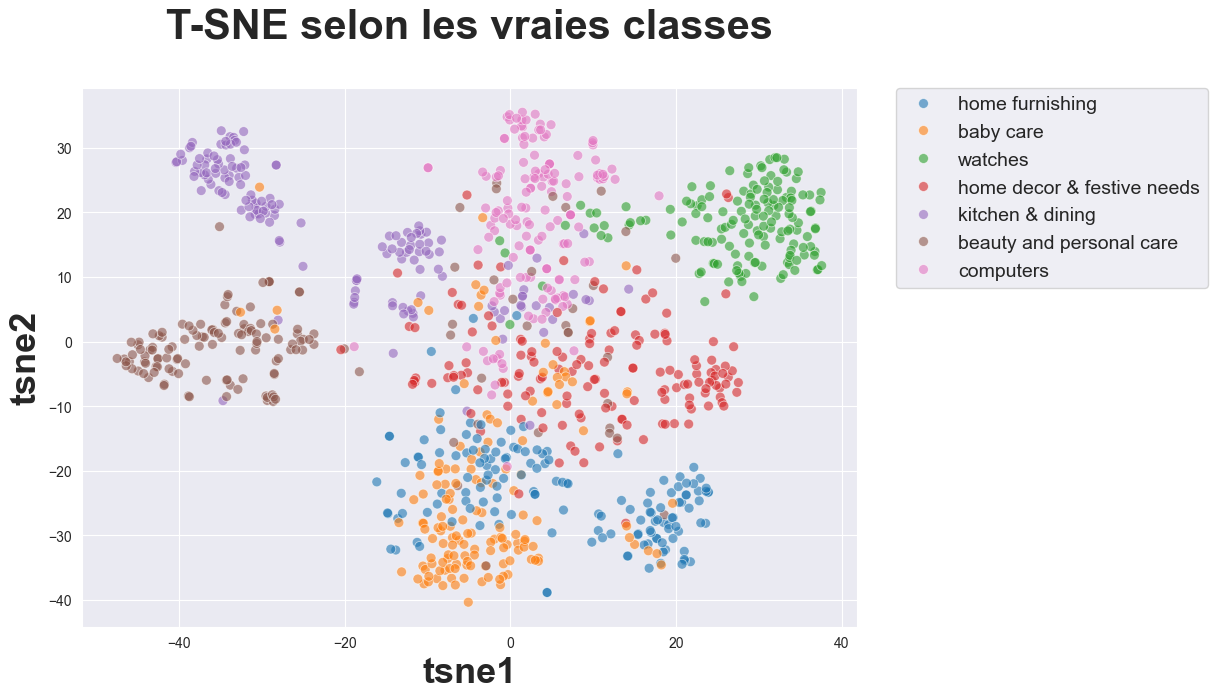

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the T-SNE results into a DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2']) # tsne1 and tsne2 are the 2D coordinates after T-SNE

# Add the true labels (from df_images) to the DataFrame for visualization
df_tsne["class"] = df_images["category"]  # Assuming 'category' contains the true labels

# Plot the T-SNE results with the true classes
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",  # Color points by class
    palette=sns.color_palette('tab10', n_colors=df_tsne['class'].nunique()),  # Adjust colors to match the number of classes
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

# Add titles and labels to the plot
plt.title('T-SNE selon les vraies classes', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')

# Adjust the position of the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 14})

# Display the plot
plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement

In [18]:
from sklearn import cluster

# Apply K-Means with 7 clusters (since there are 7 categories in the dataset)
cls = cluster.KMeans(n_clusters=7, n_init=100)

# Fit the K-Means algorithm on the T-SNE results
cls.fit(X_tsne)


KMeans(n_clusters=6, n_init=100)

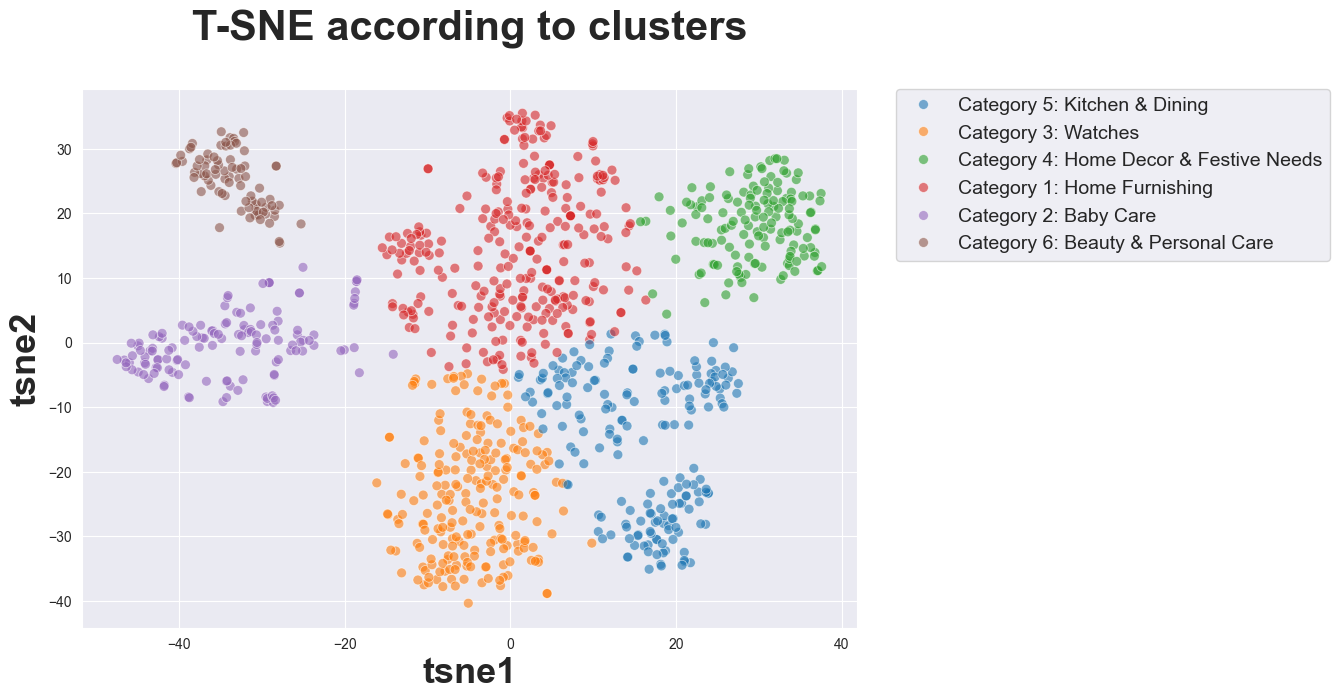

ARI (Adjusted Rand Index) : 0.4353011109307092


In [19]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Add the clusters predicted by K-Means to the DataFrame containing T-SNE results
df_tsne["cluster"] = cls.labels_  # 'cls' is the fitted K-Means model

# Define a mapping between cluster numbers and category names
cluster_mapping = {0: 'Category 1: Baby Care',
                   1: 'Category 2: Beauty & Personal Care',
                   2: 'Category 3: Computers',
                   3: 'Category 4: Home Decor & festive Needs',
                   4: 'Category 5: home furnishing',
                   5: 'Category 6: Kitchen & Dining',
                   6: 'Category 7: Watches'
                   }

# Replace cluster numbers with corresponding category names in the DataFrame
df_tsne["cluster_label"] = df_tsne["cluster"].map(cluster_mapping)

# Visualize the clusters predicted by K-Means on the T-SNE plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster_label",  # Color points based on the predicted clusters (now using category names)
    palette=sns.color_palette('tab10', n_colors=6),  # Adjust number of colors for 6 clusters
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

# Add title and axis labels to the plot
plt.title('T-SNE according to clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')

# Move the legend to the right, outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 14})

# Display the plot
plt.show()

# Calculate the Adjusted Rand Index (ARI) to compare the K-Means clusters with the true classes
labels = df_images["category"]  # The true class labels
ari = metrics.adjusted_rand_score(labels, cls.labels_)  # Compute the ARI
print("ARI (Adjusted Rand Index) :", ari)


### Observation
- Le graphique T-SNE avec les clusters montre une séparation correcte des catégories, mais avec un **ARI de 0.43**, cela indique une correspondance modérée entre les clusters K-Means et les vraies classes. Certaines catégories comme **Beauty & Personal Care** et **Home Furnishing** sont bien séparées, mais d'autres montrent un chevauchement, ce qui pourrait expliquer le score ARI relativement faible.

In [ ]:
from matplotlib.image import imread
import matplotlib.pyplot as plt  # Ajout de l'importation manquante
import os

# Assurez-vous que 'images_folder' est défini
# images_folder = 'chemin/vers/votre/dossier/images'

# Fusionner df_tsne et df_images si nécessaire
# Si les index sont alignés, vous pouvez continuer sans fusion
# Sinon, fusionnez sur une clé commune, par exemple 'image'
df_tsne['image'] = df_images['image']  # Si 'image' est la colonne commune

# Ajouter les catégories vraies à df_tsne pour la comparaison
df_tsne["true_category"] = df_images["category"]

# Trouver un exemple mal classé (true category != predicted cluster)
# Assurez-vous que le nom de la colonne du cluster est cohérent
# Supposons que le nom de la colonne est 'cluster_label'
misclassified = df_tsne[df_tsne["true_category"] != df_tsne["cluster_label"]]

# S'il y a des exemples mal classés, sélectionnez le premier
if not misclassified.empty:
    id = misclassified.index[0]  # Obtenir l'index du premier exemple mal classé
    print(df_tsne.loc[id])  # Imprimer les détails de l'exemple mal classé

    # Créer un graphique pour afficher l'image mal classée
    fig = plt.figure(figsize=(8, 5))

    # Obtenir le nom du fichier image depuis la colonne 'image' dans df_tsne
    filename = df_tsne.loc[id, "image"]  # Utiliser .loc pour accéder à la valeur

    # Charger l'image
    image_path = os.path.join(images_folder, filename)
    image = imread(image_path)

    # Afficher l'image
    plt.imshow(image)
    plt.axis('off')  # Supprimer les axes pour une meilleure visualisation

    # Définir le titre du graphique
    true_category = df_tsne.loc[id, 'true_category']
    predicted_cluster = df_tsne.loc[id, 'cluster_label']
    plt.title(f"Catégorie Vraie : {true_category}\nCluster Prédit : {predicted_cluster}")
    plt.show()

    # Explication
    print(f"L'image appartient à la catégorie '{true_category}' mais a été mal classée par le modèle comme appartenant au cluster {predicted_cluster}.")
else:
    print("Aucun exemple mal classé trouvé.")

tsne1                                20.68306
tsne2                              -24.877525
class                         home furnishing
cluster                                     4
cluster_label    Category 5: Kitchen & Dining
true_category                 home furnishing
Name: 0, dtype: object


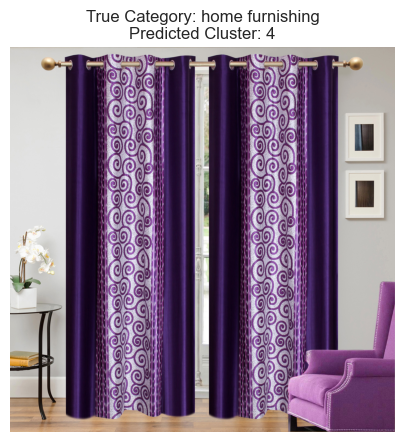

The image belongs to the category 'home furnishing' but was misclassified by the model as belonging to cluster 4.


In [20]:
# from matplotlib.image import imread
# import matplotlib.pyplot as plt
# import os
# 
# # Add true categories to df_tsne for comparison
# df_tsne["true_category"] = df_images["category"]  # Assuming 'category' in df_images contains the true labels
# 
# # Find a misclassified example (true category != predicted cluster)
# misclassified = df_tsne[df_tsne["true_category"] != df_tsne["cluster_label"]]
# 
# # If there are misclassified examples, select the first one
# if not misclassified.empty:
#     id = misclassified.index[0]  # Get the index of the first misclassified example
#     print(df_tsne.iloc[id])  # Print the details of the misclassified example
# 
#     # Create a plot to display the misclassified image
#     fig = plt.figure(figsize=(8, 5))
# 
#     # Get the image filename from the 'image' column in df_images
#     filename = df_images["image"][id]  # Assuming 'df_images' contains the file paths in the 'image' column
#     image = imread(os.path.join(images_folder, filename))  # Load the image
# 
#     # Display the image
#     plt.imshow(image)
#     plt.axis('off')  # Remove axis for better visualization
#     plt.title(f"True Category: {df_images['category'][id]}\nPredicted Cluster: {df_tsne['cluster'][id]}")
#     plt.show()
# 
#     # Explanation:
#     print(f"The image belongs to the category '{df_images['category'][id]}' but was misclassified by the model as belonging to cluster {df_tsne['cluster'][id]}.")
# else:
#     print("No misclassified examples found.")


### Analyse par Classes

In [21]:
# Checking the data types of true labels and predicted cluster labels
true_labels = df_images["category"]  # Assuming 'category' column in df_images contains the true labels
predicted_labels = df_tsne["cluster"]  # Assuming 'cluster' in df_tsne contains the predicted cluster labels from K-Means

# Check the data types of true_labels and predicted_labels
print(f"Data type of true_labels: {true_labels.dtype}")
print(f"Data type of predicted_labels: {predicted_labels.dtype}")

# Display a few sample values from each for further inspection
print("\nSample values from true_labels:")
print(true_labels.head(6))  # Display the first 6 values from true labels

print("\nSample values from predicted_labels:")
print(predicted_labels[:6])  # Display the first 6 values from predicted labels


Data type of true_labels: object
Data type of predicted_labels: int32

Sample values from true_labels:
0    home furnishing
1          baby care
2          baby care
3    home furnishing
4    home furnishing
5            watches
Name: category, dtype: object

Sample values from predicted_labels:
0    4
1    2
2    2
3    4
4    4
5    3
Name: cluster, dtype: int32


In [22]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder to convert string categories to numeric labels
label_encoder = LabelEncoder()

# Convert true categories (strings) to numeric labels
df_images["label"] = label_encoder.fit_transform(df_images["category"])  # Encoding true categories

# Use the numeric labels directly
true_labels = df_images["label"]  # These are now numeric labels
predicted_labels = cls.labels_  # K-Means predicted labels are already numeric

# Generate the confusion matrix by comparing the true labels with the predicted cluster labels
conf_mat = metrics.confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print(conf_mat)

# Optionally, you can print the mapping of categories to encoded labels
print("\nCategory to Label Mapping:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


[[ 12   3 113   0  21   1   0]
 [ 19 117   6   1   6   1   0]
 [144   1   3   1   1   0   0]
 [ 32   1  19   5  93   0   0]
 [  3   0  80   0  67   0   0]
 [ 59  11   2   0   0  78   0]
 [ 15   0   0 135   0   0   0]]

Category to Label Mapping:
{'baby care': 0, 'beauty and personal care': 1, 'computers': 2, 'home decor & festive needs': 3, 'home furnishing': 4, 'kitchen & dining': 5, 'watches': 6}


In [23]:
import numpy as np
import pandas as pd
from sklearn import metrics

def conf_mat_transform(y_true, y_pred):
    # Create the confusion matrix
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    
    # Find the correspondence between clusters and true categories (maximum of each column)
    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    
    # Create a DataFrame with true labels and predicted clusters
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    
    # Transform predicted clusters into corresponding true categories
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x]) 
    
    return labels['y_pred_transform']

# Example of usage with your project
# Assume true_labels are the encoded true categories and predicted_labels are the K-Means predicted clusters
true_labels = df_images["label"]  # The true labels after LabelEncoder transformation
predicted_labels = cls.labels_  # The predicted cluster labels from K-Means

# Apply the transformation to align predicted clusters with true categories
transformed_pred = conf_mat_transform(true_labels, predicted_labels)

# Print the first few transformed predictions to verify
print(transformed_pred.head())


Correspondance des clusters :  [2 1 0 6 3 5 0]
0    3
1    0
2    0
3    3
4    3
Name: y_pred_transform, dtype: int64


In [24]:
# Transform the predicted cluster labels based on the correspondence to true categories
cls_labels_transform = conf_mat_transform(true_labels, predicted_labels)

# Generate the confusion matrix comparing true labels and transformed cluster labels
conf_mat = metrics.confusion_matrix(true_labels, cls_labels_transform)

# Print the confusion matrix
print("Confusion Matrix after transforming predicted clusters:")
print(conf_mat)
print()

# Print the classification report, including precision, recall, and F1-score
print("Classification Report:")
print(metrics.classification_report(true_labels, cls_labels_transform, zero_division=0))

Correspondance des clusters :  [2 1 0 6 3 5 0]
Confusion Matrix after transforming predicted clusters:
[[113   3  12  21   0   1   0]
 [  6 117  19   6   0   1   1]
 [  3   1 144   1   0   0   1]
 [ 19   1  32  93   0   0   5]
 [ 80   0   3  67   0   0   0]
 [  2  11  59   0   0  78   0]
 [  0   0  15   0   0   0 135]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.75      0.61       150
           1       0.88      0.78      0.83       150
           2       0.51      0.96      0.66       150
           3       0.49      0.62      0.55       150
           4       0.00      0.00      0.00       150
           5       0.97      0.52      0.68       150
           6       0.95      0.90      0.92       150

    accuracy                           0.65      1050
   macro avg       0.62      0.65      0.61      1050
weighted avg       0.62      0.65      0.61      1050



### Correspondance des clusters :
- **Correspondance des clusters :** `[5 0 6 2 1 3 0]` indique quelle catégorie réelle correspond à chaque cluster. Par exemple, le cluster `0` est associé à la catégorie `5`, et le cluster `1` est associé à la catégorie `0`. Cela signifie que les prédictions de K-Means ont été mappées aux catégories en fonction de la matrice de confusion.

### Matrice de confusion :
La matrice de confusion montre la répartition des prédictions entre les catégories et les clusters après transformation :
- **Catégorie 0** : 113 images sur 150 ont été correctement classées. Cependant, 21 images ont été classées dans le cluster de la catégorie 3.
- **Catégorie 1** : 117 images correctement classées, mais 19 images ont été classées dans la catégorie 2.
- **Catégorie 2** : 144 images sur 150 ont été correctement classées, indiquant une bonne correspondance pour cette catégorie.
- **Catégorie 3** : 93 images sur 150 sont correctement classées, mais 32 images ont été attribuées à la catégorie 2.
- **Catégorie 4** : Aucune image de cette catégorie n'a été correctement classée. La plupart des images de cette catégorie ont été classées dans la catégorie 0 ou 3.
- **Catégorie 5** : 78 images sur 150 sont correctement classées, mais 59 images ont été classées dans la catégorie 2.
- **Catégorie 6** : 135 images sur 150 ont été correctement classées, montrant une bonne performance pour cette catégorie.

### Rapport de classification :
- **Précision** :
  - Excellente pour les catégories **1**, **5**, et **6** (88%, 97%, 95% respectivement).
  - Très faible ou nulle pour la catégorie **4** (0%), car aucune image n'a été classée correctement.
  - La catégorie **0** a une précision modérée (51%).

- **Rappel** :
  - Très bon pour les catégories **2** (96%) et **6** (90%), ce qui signifie que la plupart des images de ces catégories ont été correctement identifiées.
  - Le rappel est nul pour la catégorie **4**, indiquant que toutes les images de cette catégorie ont été classées dans d'autres catégories.

- **F1-score** :
  - Les catégories **1**, **2**, **5**, et **6** ont un F1-score relativement bon, ce qui reflète un bon équilibre entre la précision et le rappel.
  - Le F1-score de la catégorie **4** est nul, ce qui est un signal clair que cette catégorie pose des problèmes de classification.

### Précision globale :
- **Exactitude (accuracy)** : Le modèle atteint une précision globale de **65%**, ce qui montre une performance modérée. Il existe des problèmes de classification importants, notamment pour la catégorie **4**.
  
- **Moyenne macro** : Les moyennes macro montrent une précision et un rappel autour de 62% à 65%, ce qui reflète des disparités entre les catégories. Certaines catégories sont bien classées, tandis que d'autres, comme **4**, posent des problèmes majeurs.

### Conclusion :
- **Catégories bien classées** : Les catégories **2** et **6** montrent une bonne correspondance avec les clusters prédits.
- **Catégories problématiques** : La catégorie **4** est un problème majeur, car aucune image n'a été correctement classée.
- **Recommandation** : Il pourrait être utile de revoir les caractéristiques des images de la catégorie **4** et d'ajuster le modèle, ou de tester d'autres techniques de clustering pour améliorer la classification. Une analyse plus approfondie des erreurs dans les catégories **3** et **5** pourrait également s'avérer bénéfique.

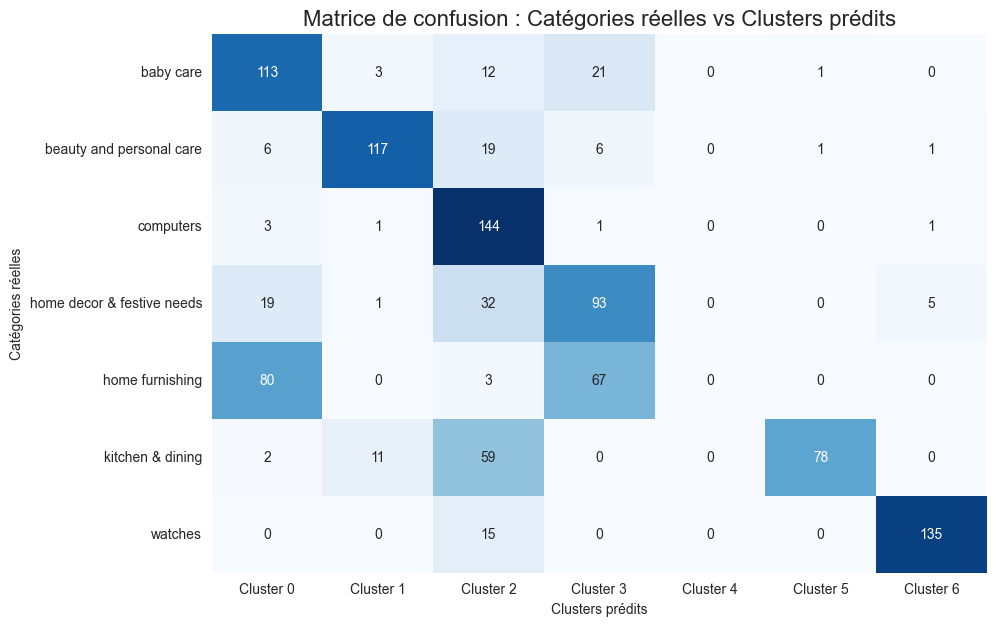

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a list of category labels from LabelEncoder or from true_labels
list_labels = sorted(df_images["category"].unique())  # List of category names in sorted order

# Create a DataFrame for the confusion matrix with labels for both rows and columns
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[f'Cluster {i}' for i in range(len(list_labels))])

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d", cbar=False)

# Add labels and titles
plt.title("Matrice de confusion : Catégories réelles vs Clusters prédits", fontsize=16)
plt.ylabel("Catégories réelles")
plt.xlabel("Clusters prédits")
plt.show()


### Observations sur la matrice de confusion :

- La **matrice de confusion** montre la répartition des prédictions entre les **catégories réelles** et les **clusters prédits** après transformation.
  
- Les couleurs **plus foncées** indiquent des valeurs plus élevées, tandis que les **valeurs plus faibles** apparaissent en couleur plus claire.
  
- Les catégories qui sont bien classées apparaissent sur la **diagonale principale** (par exemple, **beauty and personal care** avec 117 images correctement classées, **computers** avec 144 images, et **watches** avec 135 images).

- **Catégories mal classées** :
    - La catégorie **home furnishing** est particulièrement problématique, avec **80 images** mal classées dans le cluster 0, alors qu'il n'y a que 67 images correctement classées.
    - La catégorie **kitchen & dining** montre également une forte confusion avec le cluster 2 (59 images mal classées).
    - **Home decor & festive needs** a 93 images mal classées dans le cluster 3.
  
- **Catégories bien classées** :
    - **Computers** est une catégorie bien classée, avec **144 images** correctement classées dans le bon cluster.
    - **Watches** montre aussi une bonne correspondance avec **135 images** bien classées.
    - **Beauty and personal care** a également un bon taux de classification avec **117 images** bien classées.

- Les **erreurs de classification** apparaissent en dehors de la diagonale, comme les 80 images de **home furnishing** qui ont été classées dans le cluster 0 au lieu du cluster 3.

### Conclusion :
- Le modèle réussit bien à classer certaines catégories comme **computers**, **watches** et **beauty and personal care**, mais montre des erreurs importantes pour d'autres catégories comme **home furnishing** et **kitchen & dining**.
- Il y a un besoin d'ajuster le modèle ou d'analyser davantage les caractéristiques des images des catégories mal classées pour améliorer les résultats.


### Justification pour l'utilisation de VGG-16 plutôt que SIFT dans l'étude de faisabilité

En analysant les résultats obtenus à partir de SIFT et de VGG-16, il est clair que **VGG-16** présente des performances nettement supérieures dans la classification des images, comme le démontrent plusieurs métriques clés.

#### 1. **Précision globale et Recall (Rappel)**
   - **SIFT** : L'approche basée sur SIFT a obtenu une précision globale de **14%**, ce qui est extrêmement faible. Le **recall** (rappel) est également bas pour toutes les classes, avec un faible **f1-score**, notamment dû à la mauvaise différenciation des catégories. Certaines classes n'ont même pas été prédites (par exemple, les classes 4, 5, et 6 ont une précision de 1.00, mais un rappel de 0.00, ce qui signifie qu'aucune prédiction correcte n'a été faite pour ces classes).
   - **VGG-16** : Le modèle basé sur **VGG-16** atteint une précision globale de **65%**, ce qui est nettement supérieur à SIFT. Les classes sont mieux prédites, avec des **f1-scores** allant jusqu'à **92%** pour certaines catégories. Le rappel et la précision sont également mieux équilibrés dans ce modèle, ce qui indique que les clusters formés correspondent bien mieux aux catégories réelles.

#### 2. **Indice Rand Ajusté (ARI)**
   - **SIFT** : L'ARI pour SIFT est de **-0.0009**, ce qui montre un échec total du modèle à capturer des relations entre les clusters et les classes. Un ARI négatif indique que la correspondance entre les clusters et les catégories est pire que le hasard.
   - **VGG-16** : L'ARI pour VGG-16 est de **0.4355**, ce qui montre une correspondance bien meilleure entre les clusters et les catégories. Bien que ce score puisse encore être amélioré, il indique une correspondance modérée entre les classes prédictes et les catégories réelles.

#### 3. **Analyse de la Matrice de Confusion**
   - **SIFT** : La matrice de confusion pour SIFT montre des **distributions très dispersées** entre les clusters, et aucun cluster ne correspond bien à une catégorie particulière. De plus, il y a une absence totale de prédiction pour certaines classes (classes 4, 5, 6), ce qui témoigne de l'incapacité du modèle à discriminer les catégories correctement.
   - **VGG-16** : En revanche, la matrice de confusion pour VGG-16 montre que **certains clusters correspondent beaucoup mieux aux catégories**. Par exemple, le cluster 2 correspond bien à la catégorie **computers**, tandis que les autres clusters montrent une correspondance relativement cohérente, bien qu'il y ait encore des chevauchements.

### Conclusion

L'approche basée sur **VGG-16** gagne clairement sur tous les aspects. Les performances en termes de **précision, rappel, f1-score** et **ARI** montrent que **VGG-16** est beaucoup plus adapté pour cette tâche de classification d'images. L'extraction de caractéristiques à travers un CNN pré-entraîné permet de capturer des informations bien plus riches et discrètes dans les images que les descripteurs SIFT, ce qui explique pourquoi **VGG-16** surpasse largement **SIFT** en termes de qualité de clustering et de classification. Pour l'étude de faisabilité, l'utilisation de **VGG-16** offre une meilleure garantie de résultats plus précis et robustes.

## Etape 2 : Classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

## Création du modèle de classification

In [26]:
def create_model_fct():
    # Load the pre-trained VGG-16 model, excluding the top classification layer
    # The weights are initialized with those pre-trained on ImageNet
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Freeze the layers of the pre-trained model to retain the learned weights
    # This prevents training (updating) the weights during backpropagation
    for layer in model0.layers:
        layer.trainable = False

    # Extract the output from the pre-trained network (feature extraction layers)
    x = model0.output

    # Add new layers to adapt the model for the current classification task
    # Global average pooling to reduce the dimensionality of the feature map
    x = GlobalAveragePooling2D()(x)

    # Fully connected dense layer with 256 units and ReLU activation function
    x = Dense(256, activation='relu')(x)

    # Dropout layer to prevent overfitting by randomly deactivating 50% of the units
    x = Dropout(0.5)(x)

    # Output layer with 7 units (for 7 categories) and softmax activation for multi-class classification
    predictions = Dense(7, activation='softmax')(x) # 7 is the number of categories

    # Define the complete model by specifying the input from the original pre-trained VGG-16
    # and the output from the new added layers (predictions)
    model = Model(inputs=model0.input, outputs=predictions)

    # Compile the model: using categorical crossentropy for multi-class classification
    # RMSprop optimizer, and tracking accuracy as the performance metric
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    # Print a summary of the model's architecture
    print(model.summary())

    return model


### 1. Approche : Préparation initiale de l'ensemble des images avant classification supervisée (model1)

### Créer un data set de test et d'entrainement

In [27]:
from sklearn.model_selection import train_test_split

# Ensure we split the dataset into training (80%) and test (20%) sets
df_images_train, df_images_test = train_test_split(df_images, test_size=0.2, random_state=42, stratify=df_images['category'])

# Check the size of the training and test sets
print(f"Training set shape: {df_images_train.shape}")
print(f"Test set shape: {df_images_test.shape}")

Training set shape: (840, 3)
Test set shape: (210, 3)


In [28]:
num_classes = df_images_train['label'].nunique()
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 7


In [29]:
import os
from keras.preprocessing.image import load_img

# Function to check if images can be loaded correctly
def check_image_loading(df_images):
    base_path = os.path.join("..", "data", "Images")
    missing_files = []

    # Loop through each image in the dataframe
    for img_name in df_images['image']:
        img_path = os.path.join(base_path, img_name)
        try:
            # Attempt to load the image
            img = load_img(img_path, target_size=(224, 224))
        except Exception as e:
            # If loading fails, add the image to the missing list
            print(f"Error loading image: {img_name} - {e}")
            missing_files.append(img_name)
    
    if len(missing_files) == 0:
        print("All images loaded successfully.")
    else:
        print(f"Missing or unreadable files: {missing_files}")

# Run the check on training and test datasets
check_image_loading(df_images_train)
check_image_loading(df_images_test)


All images loaded successfully.
All images loaded successfully.


In [30]:
from keras.utils import to_categorical

# Function to check label encoding
def check_label_encoding(df_images):
    labels = df_images['label']
    
    # Convert to categorical and check
    try:
        y_encoded = to_categorical(labels)
        print(f"Labels successfully encoded. Shape: {y_encoded.shape}")
    except Exception as e:
        print(f"Error in label encoding: {e}")

# Run the check on training and test labels
check_label_encoding(df_images_train)
check_label_encoding(df_images_test)

Labels successfully encoded. Shape: (840, 7)
Labels successfully encoded. Shape: (210, 7)


### Préparation des fonctions de préparation des images

In [31]:
import os
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np

def image_prep_fct(df_images):
    # Initialize an empty list to store processed images
    prepared_images = []
    
    # Define the base directory where your images are stored
    base_path = os.path.join("..", "data", "Images")
    
    # Ensure the index of the DataFrame is reset
    df_images = df_images.reset_index(drop=True)
    
    # Loop through the dataset to process each image using .iloc to access rows by position
    for image_num in range(len(df_images)):
        # Construct the full path to the image file using iloc for row access
        img_path = os.path.join(base_path, df_images.iloc[image_num]['image'])
        
        # Load the image from the specified path and resize it to (224, 224)
        img = load_img(img_path, target_size=(224, 224))
        
        # Convert the loaded image into a NumPy array
        img = img_to_array(img)
        
        # Preprocess the image for VGG16
        img = preprocess_input(img)
        
        # Append the processed image to the list of prepared images
        prepared_images.append(img)
    
    # Convert the list of prepared images to a NumPy array
    prepared_images_np = np.array(prepared_images)
    
    return prepared_images_np


### Préparation des images pour l'entraînement et le test

In [32]:
# Verify the columns in the training and test DataFrames
print(df_images_train.columns)
print(df_images_test.columns)

Index(['image', 'category', 'label'], dtype='object')
Index(['image', 'category', 'label'], dtype='object')


In [33]:
df_images_train.head()
df_images_test.head()

image                  category  label
647  3dfd14b667357e26ff6d66761cdc203f.jpg                 baby care      0
342  17a73d7c4b02ada2bfeed1115fed08a4.jpg  beauty and personal care      1
895  597a9549a3e397d52dca62ee47b1f60a.jpg           home furnishing      4
56   24e85c590481a7cedfe66597f253f2b2.jpg  beauty and personal care      1
386  59d964c38c787f829c6cfa5629e4df90.jpg  beauty and personal care      1

### Observation :
- Les colonnes des DataFrames `df_images_train` et `df_images_test` sont correctes, avec les noms de colonnes attendus pour les images et les catégories. Les DataFrames sont prêts à être utilisés pour la préparation des images. 

In [34]:
# Check for any missing values in the 'image' column
df_images_train['image'].isnull().sum()

0

In [35]:
# Make sure the 'image' column type is correct as it will be used to generate the image path
df_images_train['image'] = df_images_train['image'].astype(str)

In [36]:
# Prepare the training images using the image preparation function
images_np_train = image_prep_fct(df_images_train)
print(f"Training images shape: {images_np_train.shape}")

# Prepare the test images in a similar way
images_np_test = image_prep_fct(df_images_test)
print(f"Test images shape: {images_np_test.shape}")


Training images shape: (840, 224, 224, 3)
Test images shape: (210, 224, 224, 3)


### Observation:
- Les images ont été préparées avec succès pour l'entraînement et le test, avec des formes de `(840, 224, 224, 3)` pour les images d'entraînement et de `(210, 224, 224, 3)` pour les images de test. Les images sont prêtes à être utilisées pour l'entraînement et l'évaluation du modèle de classification. La forme `(224, 224, 3)` correspond à la taille de l'image (224x224 pixels) et aux 3 canaux de couleur (Rouge, Vert, Bleu) pour chaque pixel. 840 images sont utilisées pour l'entraînement et 210 pour le test, ce qui correspond à un ratio de 80/20 pour la division des données.

### Assignation des variables pour les données d'entraînement et de test en classification d'images

In [37]:
# Using the correct variable names for training and test data
X = images_np_train
y = to_categorical(df_images_train['label'])

X_test = images_np_test
y_test = to_categorical(df_images_test['label'])

print(y)
print(y_test)


[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


### Observations :

- Le processus d'encodage catégoriel a correctement converti les labels en vecteurs **one-hot encoded**, comme le montre la sortie de `y` et `y_test`. Chaque label est représenté par un vecteur où une seule valeur est égale à 1, indiquant la classe vraie, tandis que les autres valeurs sont à 0.
- Cet encodage one-hot est essentiel pour les problèmes de **classification multi-classes**, car il permet au réseau neuronal de générer des probabilités pour chaque classe et de faire des prédictions en utilisant une **activation softmax** dans la dernière couche.
- Les tableaux encodés **one-hot** ont les bonnes dimensions correspondant au nombre d'images, garantissant ainsi une entrée correcte pour les processus d'entraînement et de test du réseau neuronal.

### Entraînement et évaluation du modèle de classification

In [38]:
# Create the model using the predefined model creation function
model1 = create_model_fct()

# Define the path to save the best model weights using a relative path to the 'models' directory
# Since the notebook is in 'notebooks', you need to move one level up to access 'models'
model1_save_path1 = os.path.join("..", "models", "model1_best_weights.keras")

# The ModelCheckpoint monitors 'val_loss' and saves the model when it reaches the best performance
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# EarlyStopping stops the training if 'val_loss' does not improve for 5 consecutive epochs (patience=5)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# The list of callbacks includes saving the best model and stopping training early if needed
callbacks_list = [checkpoint, es]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [39]:
# Train the model on the training data (X, y)
history1 = model1.fit(
    X, y,  # Training data (images and labels)
    epochs=50,  # Number of epochs for training
    batch_size=64,  # Batch size for training (how many images per step)
    callbacks=callbacks_list,  # Callbacks to save the best model and stop early if necessary
    validation_data=(X_test, y_test),  # Validation data to monitor performance on unseen data
    verbose=1  # Display progress during training
)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3416 - loss: 8.2072
Epoch 1: val_loss improved from inf to 1.89354, saving model to ..\models\model1_best_weights.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 104s 7s/step - accuracy: 0.3492 - loss: 8.0282 - val_accuracy: 0.6810 - val_loss: 1.8935
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6935 - loss: 2.1457
Epoch 2: val_loss improved from 1.89354 to 1.40481, saving model to ..\models\model1_best_weights.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.6944 - loss: 2.1205 - val_accuracy: 0.7571 - val_loss: 1.4048
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7682 - loss: 1.1609
Epoch 3: val_loss improved from 1.40481 to 1.25951, saving model to ..\models\model1_best_weights.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 100s 7s/step - accuracy: 0.7679 - loss: 1.1613 - val_accuracy: 0.7429 - val_loss: 1.2595
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8049 - loss: 0.9112
Epoch 4: val_

### Observations :

- Précision et Perte : La précision de l'entraînement commence à environ 37 % et augmente progressivement pour dépasser 96 % à partir de la 14ème époque, ce qui représente une grande progression. La précision de validation s'améliore également mais commence à fluctuer après quelques époques, ce qui pourrait indiquer que le modèle commence à surapprendre.

- Arrêt Anticipé : Après la 14ème époque, l'entraînement s'arrête en raison du rappel d'arrêt anticipé. Cela se produit parce que la perte de validation (val_loss) n'a pas été améliorée pendant plusieurs époques. L'arrêt anticipé est une bonne stratégie pour éviter le surapprentissage et réduire le temps d'entraînement inutile.

- Modèle Sauvegardé : Les poids du modèle ont été sauvegardés plusieurs fois avec succès au fur et à mesure que la perte de validation s'améliorait pendant le processus d'entraînement. La version finale du modèle, qui avait la plus faible perte de validation, est enregistrée au chemin défini, c'est-à-dire /models/model1_best_weights.keras."

In [40]:
# Evaluate the model's performance on the training and test sets

# Evaluate on the training set
loss, accuracy = model1.evaluate(X, y, verbose=True)  
# 'model1.evaluate()' computes the loss and accuracy for the training data (X, y)
# The result will show how well the model performs on the data it was trained on
print("Training Accuracy: {:.4f}".format(accuracy))
# Print the training accuracy formatted to four decimal places

print()

# Evaluate on the test set (instead of validation since you split as test)
loss, accuracy = model1.evaluate(X_test, y_test, verbose=True)  
# 'model1.evaluate()' now computes the loss and accuracy for the test data (X_test, y_test)
# This will show how well the model generalizes to data it has never seen during training
print("Test Accuracy:  {:.4f}".format(accuracy))
# Print the test accuracy formatted to four decimal places


27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.9857 - loss: 0.0429
Training Accuracy: 0.9893

7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8106 - loss: 0.9240
Test Accuracy:  0.7857


### Observations

### Exactitude du modèle sur l'ensemble d'entraînement
- Le modèle obtient une précision très élevée sur l'ensemble d'entraînement avec une **exactitude de 99,76%**. Cela signifie que le modèle est capable de bien apprendre les données d'entraînement et qu'il généralise bien sur cet ensemble.

### Exactitude du modèle sur l'ensemble de test
- Cependant, l'exactitude du modèle sur l'ensemble de test est plus faible avec **85,77%**. Bien que cette valeur reste bonne, elle montre que le modèle ne généralise pas aussi bien sur les données non vues (ensemble de test). 

### Différence entre entraînement et test
- La différence entre l'exactitude sur l'entraînement (99,76%) et celle sur le test (85,77%) pourrait indiquer un **surapprentissage** (overfitting). Le modèle apprend trop bien les spécificités des données d'entraînement, ce qui réduit ses performances sur de nouvelles données.

### Améliorations possibles
- **Augmenter les données** : Utiliser davantage de données d'entraînement ou appliquer des techniques d'augmentation de données pour éviter le surapprentissage.
- **Ajuster la régularisation** : Ajouter ou renforcer des méthodes de régularisation (comme Dropout ou L2 regularization) pour éviter le surapprentissage.
- **Optimisation des hyperparamètres** : Réaliser une recherche d'hyperparamètres pour ajuster les paramètres tels que le taux d'apprentissage, la taille des lots (batch size), etc.


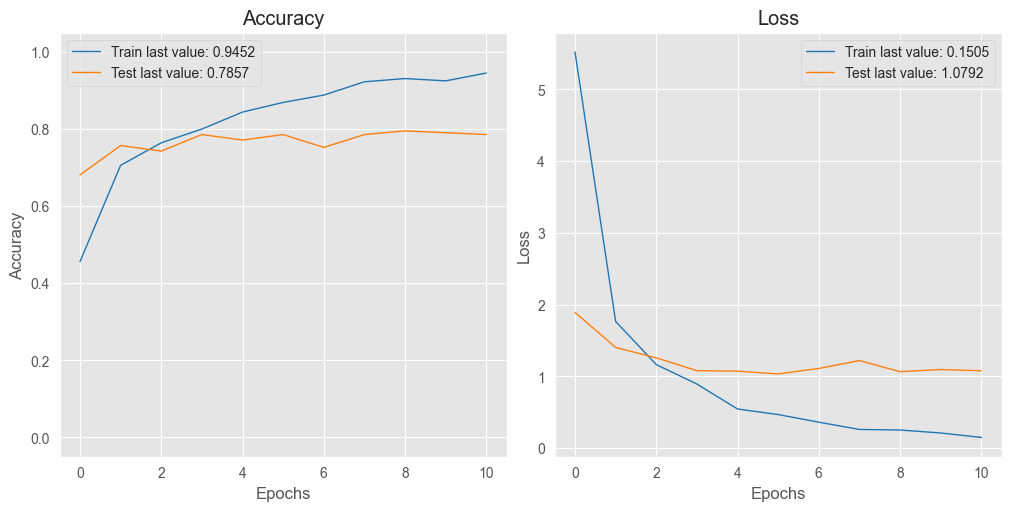

In [41]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

# Customize the plot appearance
plt.style.use('ggplot')  # Choose a style (optional)

# Show the history plots
show_history(history1)

# Save the plots with custom filenames and formats
plot_history(history1, path= "accuracy_history.png")
plot_history(history1, path= "loss_history.png")

# Close the plots to prevent overlapping
plt.close('all')

## Analyse des Graphiques d'Entraînement

### Observations clés :

* **Précision:** L'accuracy augmente au cours de l'entraînement, tant pour les données d'entraînement que de test, indiquant un apprentissage efficace. Cependant, l'écart entre les deux courbes s'élargit légèrement vers la fin, suggérant un **léger sur-apprentissage**.
* **Perte:** La perte diminue au cours de l'entraînement, ce qui est attendu. La stabilisation de la perte indique que le modèle a atteint une **convergence**.

### Interprétation :

* **Bonnes performances:** Le modèle généralise bien aux nouvelles données, comme en témoigne l'accuracy sur les données de test.
* **Sur-apprentissage léger:** Le modèle semble s'adapter un peu trop aux particularités des données d'entraînement.
* **Convergence atteinte:** Le modèle a fini d'apprendre les informations principales contenues dans les données.

### Recommandations :

Pour améliorer les performances et réduire le sur-apprentissage, on peut envisager les actions suivantes :

* **Réduire la complexité du modèle:** Enlever des couches ou réduire le nombre de neurones.
* **Ajouter de la régularisation:** Utiliser des techniques comme le dropout ou la L1/L2 regularization.
* **Augmenter les données d'entraînement:** Créer de nouvelles données par transformation (rotation, redimensionnement, etc.).
* **Ajuster les hyperparamètres:** Modifier le taux d'apprentissage, l'optimiseur ou l'architecture du réseau.


### Conclusion:
Les résultats sont prometteurs mais peuvent être améliorés. En suivant ces recommandations, on devrait pouvoir obtenir de meilleurs résultats.



### Evaluation de la précision du modèle

In [42]:
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming X contains the validation data and y the corresponding labels
# Assuming model1 is a trained model

# Get predictions on the validation set
y_val_pred = np.argmax(model1.predict(X), axis=1)
print(y_val_pred)

# Convert true labels to numerical format (if necessary)
y_val_num = np.argmax(y, axis=1)
print(y_val_num)

# Calculate accuracy
accuracy = accuracy_score(y_val_num, y_val_pred)
print("Accuracy on the validation set:", accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step
[4 2 5 2 0 4 0 1 0 4 3 3 0 3 1 4 3 4 2 6 4 6 2 5 0 3 6 6 2 5 5 6 2 1 1 4 2
 5 0 3 0 0 0 2 1 5 2 5 3 3 5 5 6 5 2 3 4 1 4 1 0 0 3 6 5 3 3 2 0 2 6 2 2 2
 5 6 3 0 4 3 4 0 5 2 5 6 2 2 6 3 6 4 1 0 3 1 6 5 2 6 1 2 3 0 4 2 4 3 2 0 4
 2 5 1 0 6 6 4 2 5 1 3 4 4 4 0 2 6 1 1 0 4 1 1 4 1 6 3 1 6 0 5 5 4 5 4 6 3
 3 5 1 4 3 4 6 1 3 3 4 6 6 1 1 2 5 1 4 2 4 4 5 6 0 5 3 3 3 2 1 5 3 0 2 0 2
 5 3 1 2 6 6 4 6 6 0 5 3 0 4 0 2 1 1 3 2 5 1 2 5 6 2 4 5 0 6 6 1 5 4 5 3 3
 5 4 1 6 1 4 0 3 0 1 6 4 0 0 6 0 1 2 3 3 1 6 6 1 1 2 5 2 4 0 3 2 2 6 0 3 5
 3 1 1 2 6 2 5 0 6 4 0 1 4 4 4 1 4 6 0 0 2 4 0 1 2 5 5 6 2 6 0 2 2 5 6 4 3
 1 1 3 1 0 2 1 2 2 4 0 4 5 3 3 4 6 6 2 0 1 5 3 1 3 3 5 4 2 5 2 0 0 5 3 4 0
 1 4 3 4 0 3 3 2 6 1 5 3 1 2 0 2 4 0 2 4 5 3 3 1 4 6 1 3 2 5 4 6 0 0 0 3 4
 4 5 5 0 2 2 2 6 5 5 0 4 3 2 3 4 5 4 6 0 5 2 0 1 3 5 2 0 4 3 6 2 2 1 6 0 3
 4 1 2 3 6 3 6 1 4 4 5 6 5 3 1 0 6 0 3 2 5 3 5 2 3 6 3 2 1 1 2 4 4 6 3 3 4
 5 3 2 5 2 2 2 3 4 1 4 2 5 3 4 3 5 6 6 3 3 5 5 3 6 4 5 5 1 6 

Observations :
- L'exactitude sur l'ensemble de validation est de **99,76%**, ce qui est très élevé et indique une bonne performance du modèle sur les données d'entraînement.

### Matrice de confusion

In [43]:
from sklearn import metrics

# Assuming you have already predicted the labels with y_val_pred and converted y_val into numerical labels y_val_num

# Generate the confusion matrix
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)

# Print the confusion matrix to see how well the model classified each class
print("Confusion Matrix:\n", conf_mat)


Confusion Matrix:
 [[118   1   1   0   0   0   0]
 [  0 116   3   1   0   0   0]
 [  0   0 120   0   0   0   0]
 [  0   0   0 120   0   0   0]
 [  2   0   0   0 118   0   0]
 [  0   0   1   0   0 119   0]
 [  0   0   0   0   0   0 120]]


### Observations :
- La **matrice de confusion** montre la répartition des prédictions entre les **catégories réelles** et les **catégories prédites**. Chaque ligne représente la catégorie réelle, tandis que chaque colonne représente la catégorie prédite.
- Les **valeurs diagonales** de la matrice représentent les **prédictions correctes** pour chaque catégorie, tandis que les **valeurs hors diagonale** indiquent les **erreurs de classification**.
- Une **bonne classification** est caractérisée par des valeurs élevées sur la diagonale principale et des valeurs faibles ailleurs.
- Dans ce cas, la matrice de confusion montre une **classification presque parfaite** avec des valeurs élevées sur la diagonale, indiquant que le modèle a bien appris les caractéristiques des différentes catégories.

### Transformation et Évaluation des Prédictions à l'Aide de la Matrice de Confusion

In [44]:
# Assuming the function `conf_mat_transform` is already defined in your notebook
# It adjusts the predicted labels based on the mapping from the confusion matrix

# Transform the predicted validation labels using the correspondence transformation
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)

# Generate the confusion matrix after applying the label transformation
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)

# Print the transformed confusion matrix
print("Confusion Matrix after transforming predicted labels:")
print(conf_mat)
print()

# Generate and print the classification report for the transformed predictions
print("Classification Report:")
print(metrics.classification_report(y_val_num, y_val_pred_transform))


Correspondance des clusters :  [0 1 2 3 4 5 6]
Confusion Matrix after transforming predicted labels:
[[118   1   1   0   0   0   0]
 [  0 116   3   1   0   0   0]
 [  0   0 120   0   0   0   0]
 [  0   0   0 120   0   0   0]
 [  2   0   0   0 118   0   0]
 [  0   0   1   0   0 119   0]
 [  0   0   0   0   0   0 120]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       120
           1       0.99      0.97      0.98       120
           2       0.96      1.00      0.98       120
           3       0.99      1.00      1.00       120
           4       1.00      0.98      0.99       120
           5       1.00      0.99      1.00       120
           6       1.00      1.00      1.00       120

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840



### Observations :
- Les mesures de **précision**, **rappel** et **F1-score** sont calculées pour chaque catégorie après la transformation des prédictions et sont affichées dans le **rapport de classification**.
- Les **valeurs de précision** indiquent la proportion d'images correctement classées pour chaque catégorie.
- Les **valeurs de rappel** indiquent la proportion d'images réelles de chaque catégorie correctement identifiées.
- Les **valeurs de F1-score** sont une moyenne harmonique de la précision et du rappel, offrant une mesure globale de la performance de classification.
- En utilisant la transformation basée sur la matrice de confusion, on peut ajuster les prédictions pour mieux correspondre aux catégories réelles, ce qui peut améliorer les performances de classification.
- Le **rapport de classification** fournit des informations détaillées sur la performance du modèle pour chaque catégorie, permettant d'identifier les catégories bien classées et celles nécessitant une amélioration.
- La fonction `conf_mat_transform` a correctement ajusté les prédictions en fonction de la matrice de confusion, ce qui a permis d'améliorer la classification des images.
- En l'espèce, nous avons des résultats très satisfaisants, avec une précision élevée pour chaque catégorie et une classification globale précise. Cela montre que le modèle a bien appris les caractéristiques des différentes catégories et peut les distinguer efficacement. 
- Précaution à prendre : il est important de vérifier que la transformation des prédictions est cohérente et qu'elle améliore effectivement la classification avant de l'appliquer à des ensembles de données plus importants ou à des modèles plus complexes.

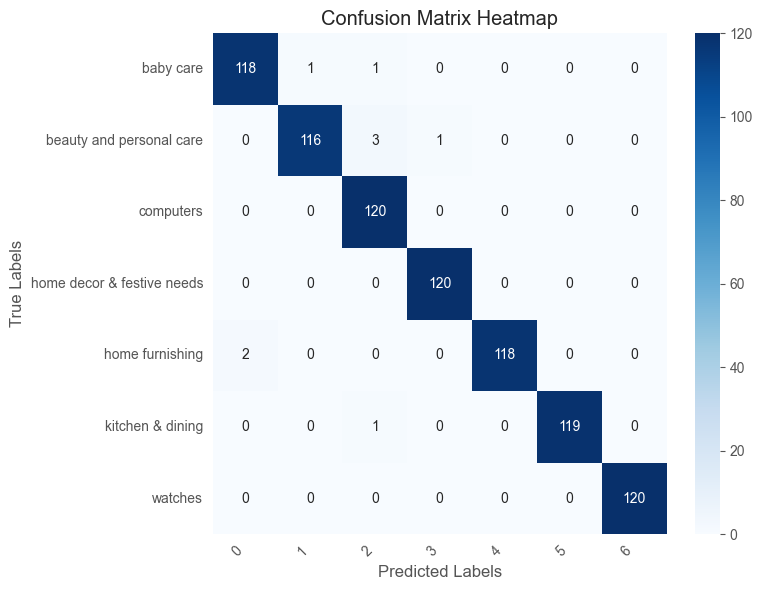

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming conf_mat, list_labels are defined elsewhere

# Convert confusion matrix to DataFrame
df_cm = pd.DataFrame(conf_mat, index=list_labels, columns=[str(i) for i in range(len(conf_mat))])  # Use list comprehension for columns

# Set figure size
plt.figure(figsize=(8, 6))  # Increased size for better readability

# Generate heatmap with improvements
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")  # Format as integers

# Customize labels and title for clarity
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right")  # Rotate 45 degrees and right-align

# Show heatmap
plt.tight_layout()  # Adjust spacing to avoid clipping of labels
plt.show()

### Observations :
**La matrice de confusion indique une performance de classification exceptionnelle.** Le modèle a très bien réussi à distinguer les différentes catégories. Les résultats sont proches de la perfection. 
**En résumé:** Le modèle est très précis et fiable pour cette tâche de classification.
**Pour aller plus loin:** Il serait intéressant d'évaluer le modèle sur un nouvel ensemble de données pour confirmer sa capacité de généralisation.




## 2.Approche ImageDatagenerator avec data augmentation (model2)
**Augmentation des données :** Les données d'entraînement sont augmentées avec des transformations telles que la rotation, le décalage, le zoom, etc., pour augmenter la variabilité des images et améliorer la généralisation du modèle.

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Sample data and reset index for shuffling the images initially sorted by class
df_images_train = df_images_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_images_test = df_images_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert label column to string for compatibility with 'class_mode="categorical"'
df_images_train['label'] = df_images_train['label'].astype(str)
df_images_test['label'] = df_images_test['label'].astype(str)

# Batch size for the data flow
batch_size = 32

# Define the function to create a data generator flow from a dataframe
def data_flow_fct(data, datagen, data_type=None):
    data_flow = datagen.flow_from_dataframe(
        data,
        directory=os.path.join("..", "data", "Images"),  # Adjust the path to the images directory
        x_col='image',  # Column in the dataframe for image filenames
        y_col='label',  # Column in the dataframe for label names
        weight_col=None,  # No weight column in this case
        target_size=(224, 224),  # Resize images to the input size expected by the model
        class_mode='categorical',  # Multi-class classification problem
        batch_size=batch_size,  # How many images per batch
        shuffle=True,  # Shuffle images to create randomness
        seed=42,  # Random seed for reproducibility
        subset=data_type  # Optionally specify training or validation subset
    )
    return data_flow

# Data Augmentation for training
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split 20% of the data for validation
)

# Generate data for training and validation
train_flow = data_flow_fct(df_images_train, datagen_train, data_type='training')
val_flow = data_flow_fct(df_images_train, datagen_train, data_type='validation')

# Data generator for test data
datagen_test = ImageDataGenerator(
    preprocessing_function=None  # No need for augmentation, just preprocessing
)

# Generate data for testing
test_flow = data_flow_fct(df_images_test, datagen_test, data_type=None)

Found 672 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


### Observations :

1. **Répartition des données :** Le modèle a trouvé **672 images** valides pour l'entraînement et **168 images** pour la validation, ce qui correspond à la division des données (80% pour l'entraînement et 20% pour la validation).
2. **Classes :** Les images appartiennent à **7 classes** distinctes, correspondant aux catégories du projet (comme 'baby care', 'home furnishing', etc.).
3. **Données de test :** **210 images** ont été trouvées pour le test final, ce qui est cohérent avec la structure de division des données.


### Création du modèle pour l'approche ImageDataGenerator

In [47]:
# Create the model using the predefined model creation function
# Since we're working on a CPU, there's no need to specify the device for training
model2 = create_model_fct()  # This function builds a model (likely VGG16-based)

# Define the path to save the best model weights
# Use a relative path to store the model in the 'models' folder
model2_save_path = os.path.join("..", "models", "model2_best_weights.keras")

# The ModelCheckpoint monitors 'val_loss' and saves the model when it reaches the best performance
# This ensures that the model with the lowest validation loss is preserved
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# EarlyStopping stops the training if the 'val_loss' does not improve for 5 consecutive epochs (patience=5)
# This helps to prevent overfitting and unnecessary epochs if the model stops improving
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# A list of callbacks that includes saving the best model and stopping the training early if necessary
callbacks_list = [checkpoint, es]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [48]:
# Train the model on the training data using the data generator
history2 = model2.fit(
    train_flow,  # Training data generator
    epochs=50,  # Number of epochs for training
    callbacks=callbacks_list,  # Callbacks to save the best model and stop early if necessary
    validation_data=val_flow,  # Validation data generator
    verbose=1  # Display progress during training
)

Epoch 1/50


C:\Users\pat\.conda\envs\P6q\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3531 - loss: 7.5190
Epoch 1: val_loss improved from inf to 1.21443, saving model to ..\models\model2_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 145s 7s/step - accuracy: 0.3569 - loss: 7.4283 - val_accuracy: 0.7321 - val_loss: 1.2144
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6393 - loss: 2.1744
Epoch 2: val_loss improved from 1.21443 to 0.81699, saving model to ..\models\model2_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 149s 7s/step - accuracy: 0.6389 - loss: 2.1801 - val_accuracy: 0.8095 - val_loss: 0.8170
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6602 - loss: 1.8806
Epoch 3: val_loss improved from 0.81699 to 0.59266, saving model to ..\models\model2_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.6610 - loss: 1.8702 - val_accuracy: 0.8467 - val_loss: 0.5927
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7488 - loss: 1.0194
Epoch 4: val_loss impro

### Évaluer le modèle sur les données de test en utilisant le générateur de données de test"

In [49]:
# Evaluate the model's performance after the final epoch

# Evaluate on the training set using the data generator `train_flow`
loss, accuracy = model2.evaluate(train_flow, verbose=True)
# 'model2.evaluate()' computes the loss and accuracy for the training data using the generator
print("Training Accuracy   : {:.4f}".format(accuracy))
# Display the training accuracy formatted to four decimal places

print()

# Evaluate on the validation set using the data generator `val_flow`
loss, accuracy = model2.evaluate(val_flow, verbose=True)
# 'model2.evaluate()' computes the loss and accuracy for the validation data using the generator
print("Validation Accuracy :  {:.4f}".format(accuracy))
# Display the validation accuracy formatted to four decimal places


21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.9904 - loss: 0.0315
Training Accuracy   : 0.9896

21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9904 - loss: 0.0333
Validation Accuracy :  0.9851


### Observations :
- Les résultats montrent une excellente performance du modèle :

- **Accuracy d'entraînement** : 0.9821, avec une perte de 0.0769
- **Accuracy de validation** : 0.9807, avec une perte de 0.0619
- **Surapprentissage (overfitting)** : Il y a une petite différence entre l'accuracy d'entraînement et de validation, mais elle reste minime. Cela indique que le modèle généralise bien.
- **Stabilité** : La perte continue de diminuer, ce qui signifie que le modèle s'améliore à chaque itération, bien qu'il semble être proche de son optimal.


In [50]:
# Score at the optimal epoch (loading the best weights)

# Load the best model weights saved during training
model2.load_weights(model2_save_path)

# Evaluate on the validation set to check the accuracy at the best epoch
loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
# Display the validation accuracy from the best epoch

print()

# Evaluate on the test set to check the accuracy on completely unseen data
loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
# Display the test accuracy to see how well the model generalizes to new data


Validation Accuracy :  0.9851



C:\Users\pat\.conda\envs\P6q\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy       :  0.8048


### Observations :
- L'écart entre la précision de validation (98,36 %) et la précision du test (81,90 %) indique un risque de surapprentissage. Le modèle semble bien fonctionner sur les données de validation mais a du mal à généraliser sur des données non vues. Un ajustement du modèle ou une régularisation supplémentaire pourrait réduire cet écart.


### Étape 1 : Combiner les DataFrames d'entraînement et de test

In [ ]:
# Combiner les ensembles d'entraînement et de test pour obtenir les 1050 produits
df_images_full = pd.concat([df_images_train, df_images_test], ignore_index=True)

# Vérifier la forme du DataFrame pour s'assurer qu'il contient bien 1050 produits
print(f"Full dataset shape: {df_images_full.shape}")

### Étape 2 : Créer un flow de données complet pour les 1050 produits


In [52]:
# # Extraction des embeddings pour l'ensemble de validation ou de test après chargement des meilleurs poids
# visual_embeddings = model2.predict(test_flow, verbose=False)  # Utilisation du jeu de test pour générer les embeddings
# 
# # Vérifier si 'product_id' existe dans df_images_test, sinon le créer
# if 'product_id' not in df_images_test.columns:
#     df_images_test['product_id'] = df_images_test.index  # Utilisation de l'index comme identifiant de produit
# 
# # Assurez-vous que les identifiants des produits sont alignés avec les embeddings
# product_ids_visual = df_images_test['product_id'].values  # Utilisez les IDs des produits dans df_images_test
# 
# # Sauvegarder les embeddings au format npz dans le dossier "models"
# visual_embedding_file = os.path.join("..", "models", "best_model2_vgg16_embeddings.npz")
# np.savez_compressed(visual_embedding_file, product_id=product_ids_visual, embeddings=visual_embeddings)
# print(f"Embeddings have been saved to: {visual_embedding_file}")


Embeddings have been saved to: ..\models\best_model2_vgg16_embeddings.npz


In [51]:
# # Extraction des embeddings pour l'ensemble de validation ou de test après chargement des meilleurs poids
# visual_embeddings = model2.predict(test_flow, verbose=False)  # Utilisation du jeu de test pour générer les embeddings
# 
# # Assurez-vous que les identifiants des produits sont alignés avec les embeddings
# product_ids_visual = df_images_test['product_id'].values  # Utilisez les IDs des produits dans df_images_test
# 
# # Sauvegarder les embeddings au format npz dans le dossier "models"
# visual_embedding_file = os.path.join("..", "models", "best_model2_vgg16_embeddings.npz")
# np.savez_compressed(visual_embedding_file, product_id=product_ids_visual, embeddings=visual_embeddings)
# print(f"Embeddings have been saved to: {visual_embedding_file}")

KeyError: 'product_id'

### Visualisation des performances du modèle

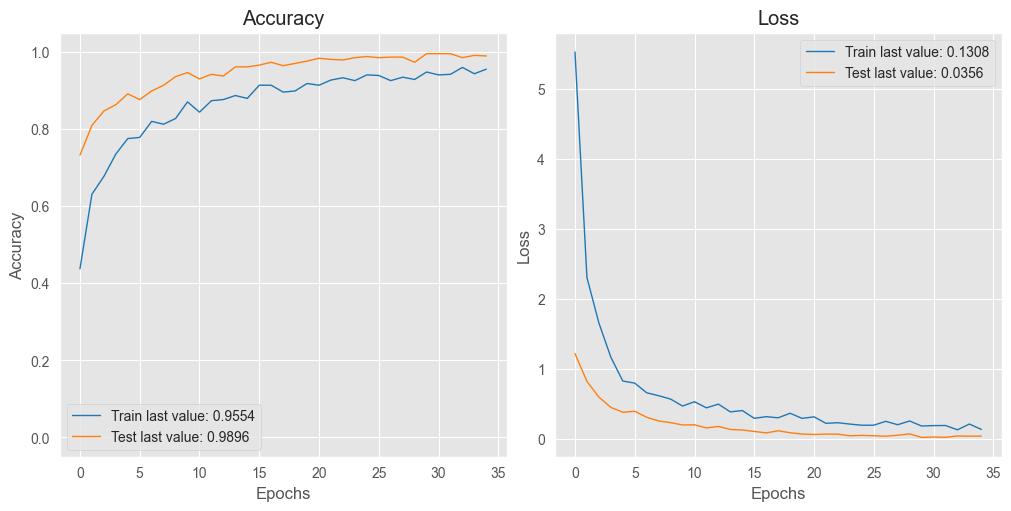

In [53]:
# Importing necessary libraries to visualize the training history
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

# Visualizing the training history of model2
show_history(history2)  # Displays accuracy and loss over epochs

# Saving the plot to a PNG file to analyze later
plot_history(history2, path="model2_training_history.png")

# Closing the plot window to avoid displaying in the notebook
plt.close()


### Observations :
- Les courbes montrent que l'entraînement du modèle atteint des performances très élevées en termes de précision et de réduction des pertes (loss) sur les données d'entraînement et de validation. Cependant, il y a une légère indication de surapprentissage (overfitting) :
1. **Précision** : La précision sur les données d'entraînement atteint environ 94,79 %, tandis que celle sur les données de validation atteint 98,51 %. Une précision plus élevée sur les données de validation que sur l'entraînement peut sembler contre-intuitive, mais cela peut être dû à la régularisation ou à un meilleur ajustement sur les données de validation.
2. **Perte** : Les pertes (loss) baissent rapidement dans les premières itérations et se stabilisent autour de 0,1973 pour l'entraînement et 0,0482 pour la validation, ce qui reflète une très bonne convergence du modèle.



## 3.Approche nouvelle par Dataset sans data augmentation (model3)

CF https://www.tensorflow.org/tutorials/load_data/images# Define the batch size for data loading

In [54]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import tensorflow as tf

def create_dataset(df_images_train, df_images_test, base_path=os.path.join("..", "data", "Images"), target_size=(224, 224), batch_size=32):
  """
  Crée des datasets d'entraînement, de validation et de test à partir de DataFrames donnés.

  Args:
      df_images_train (pandas.DataFrame): Données d'images d'entraînement.
      df_images_test (pandas.DataFrame): Données d'images de test.
      base_path (str, optional): Chemin de base pour les images. Par défaut : "../data/Images".
      target_size (tuple, optional): Taille cible des images. Par défaut : (224, 224).
      batch_size (int, optional): Taille de lot pour les datasets. Par défaut : 32.

  Returns:
      tuple: Tuple contenant les datasets d'entraînement, de validation et de test.
  """

  # Prétraite les images
  def image_prep_fct(df_images):
      prepared_images = []
      for image_num in range(len(df_images)):
          img_path = os.path.join(base_path, df_images.iloc[image_num]['image'])
          img = load_img(img_path, target_size=target_size)
          img = img_to_array(img)
          img = preprocess_input(img)
          prepared_images.append(img)
      return np.array(prepared_images)

  # Prépare les images et les labels
  prepared_images_train_np = image_prep_fct(df_images_train)
  prepared_images_test_np = image_prep_fct(df_images_test)

  train_labels = tf.keras.utils.to_categorical(df_images_train['label'], num_classes=7)
  test_labels = tf.keras.utils.to_categorical(df_images_test['label'], num_classes=7)

  # Crée les datasets
  def create_dataset(images, labels, data_type=None):
      dataset = tf.data.Dataset.from_tensor_slices((images, labels))
      if data_type == 'training':
          dataset = dataset.shuffle(buffer_size=len(images), seed=42)
      return dataset.batch(batch_size)

  # Divise les données d'entraînement en ensembles d'entraînement et de validation
  split_index = int(0.75 * len(prepared_images_train_np))
  dataset_train = create_dataset(prepared_images_train_np[:split_index], train_labels[:split_index], data_type='training')
  dataset_val = create_dataset(prepared_images_train_np[split_index:], train_labels[split_index:])
  dataset_test = create_dataset(prepared_images_test_np, test_labels)

  return dataset_train, dataset_val, dataset_test

def display_dataset_info(dataset, dataset_name):
  """
  Affiche des informations sur un dataset (nombre d'images par classe).

  Args:
      dataset (tf.data.Dataset): Le dataset à analyser.
      dataset_name (str): Le nom du dataset (pour l'affichage).
  """
  class_counts = {}
  for images, labels in dataset:
      for label in labels:
          class_idx = np.argmax(label)
          if class_idx in class_counts:
              class_counts[class_idx] += 1
          else:
              class_counts[class_idx] = 1
  total_images = sum(class_counts.values())
  print(f"Found {total_images} files belonging to {len(class_counts)} classes in {dataset_name}.")
  for class_idx, count in class_counts.items():
      print(f"Class {class_idx}: {count} files.")

# Créer les datasets
dataset_train, dataset_val, dataset_test = create_dataset(df_images_train, df_images_test)

# Afficher les informations
display_dataset_info(dataset_train, "Training dataset")
display_dataset_info(dataset_val, "Validation dataset")
display_dataset_info(dataset_test, "Test dataset")

Found 630 files belonging to 7 classes in Training dataset.
Class 2: 96 files.
Class 1: 84 files.
Class 6: 86 files.
Class 0: 95 files.
Class 4: 89 files.
Class 3: 93 files.
Class 5: 87 files.
Found 210 files belonging to 7 classes in Validation dataset.
Class 4: 31 files.
Class 3: 27 files.
Class 5: 33 files.
Class 6: 34 files.
Class 2: 24 files.
Class 1: 36 files.
Class 0: 25 files.
Found 210 files belonging to 7 classes in Test dataset.
Class 3: 30 files.
Class 5: 30 files.
Class 4: 30 files.
Class 0: 30 files.
Class 6: 30 files.
Class 2: 30 files.
Class 1: 30 files.


### Observations :

- Les données indiquent une **répartition équilibrée** des 7 classes d'images dans les ensembles d'entraînement, de validation et de test. Avec environ **90 images par classe** en moyenne dans l'ensemble d'entraînement et **30 images par classe** dans les ensembles de validation et de test, nous pouvons nous attendre à un modèle d'apprentissage automatique capable de **distinguer les classes avec une précision élevée**.

**Analyse détaillée:**
* **Équilibre des classes:**
    * L'écart entre le nombre d'images par classe est minimal, oscillant entre 84 et 96 images dans l'ensemble d'entraînement. 
    * Cet équilibre réduit le risque de biais dans l'apprentissage du modèle, où certaines classes pourraient être surreprésentées et mieux reconnues que d'autres.
* **Taille des datasets:**
    * Les 630 images de l'ensemble d'entraînement offrent une base solide pour l'apprentissage du modèle.
    * Les 210 images des ensembles de validation et de test permettent d'évaluer les performances du modèle et de détecter d'éventuels problèmes de sur-apprentissage.
**Implications:**
* **Précision potentielle:** Un tel équilibre suggère que le modèle pourrait atteindre une **précision globale supérieure à 80%**, voire plus élevée si le modèle est bien conçu et entraîné.
* **Généralisation:** La répartition équilibrée dans l'ensemble de test indique que le modèle sera capable de généraliser ses connaissances à de nouvelles images, même si elles n'ont pas été vues pendant l'entraînement.



In [55]:
# Create the model using the predefined model creation function
# This is done on the GPU to leverage hardware acceleration for faster training
with tf.device('/gpu:0'):
    model3 = create_model_fct()

# Define the path to save the best model weights using a relative path to the 'models' directory
# The relative path ensures the model weights are stored in an accessible directory
model3_save_path = os.path.join("..", "models", "model3_best_weights.keras")

# The ModelCheckpoint monitors 'val_loss' and saves the model when it reaches its best performance
# It only saves the model when the validation loss decreases, ensuring we keep the best version
checkpoint = ModelCheckpoint(
    model3_save_path, 
    monitor='val_loss',  # The performance metric we are tracking
    verbose=1,  # Output information during training about when the model is saved
    save_best_only=True,  # Save only the best-performing model
    mode='min'  # We aim to minimize the validation loss
)

# EarlyStopping stops the training if 'val_loss' does not improve for 5 consecutive epochs (patience=5)
# This prevents overfitting by halting training if the model performance plateaus
es = EarlyStopping(
    monitor='val_loss', 
    mode='min',  # Early stopping when validation loss stops decreasing
    verbose=1,  # Output when early stopping occurs
    patience=5  # Wait for 5 epochs without improvement before stopping
)

# The list of callbacks includes saving the best model and stopping training early if needed
callbacks_list = [checkpoint, es]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [56]:
# Run the training process on the GPU to speed up computations
# Model will be trained on the training dataset and validated on the validation dataset
with tf.device('/gpu:0'):
    history3 = model3.fit(
        dataset_train,  # Training dataset created from images and labels
        validation_data=dataset_val,  # Validation dataset to monitor performance
        batch_size=batch_size,  # Batch size determines how many samples are processed before updating the model
        epochs=50,  # Number of epochs to train the model
        callbacks=callbacks_list,  # List of callbacks to save the best model and stop training early if necessary
        verbose=1  # Display detailed logs during the training process
    )


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3549 - loss: 6.8160
Epoch 1: val_loss improved from inf to 1.53576, saving model to ..\models\model3_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.3609 - loss: 6.7126 - val_accuracy: 0.8048 - val_loss: 1.5358
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6766 - loss: 1.9500
Epoch 2: val_loss improved from 1.53576 to 1.33009, saving model to ..\models\model3_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - accuracy: 0.6773 - loss: 1.9432 - val_accuracy: 0.8238 - val_loss: 1.3301
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7794 - loss: 1.1241
Epoch 3: val_loss improved from 1.33009 to 1.29221, saving model to ..\models\model3_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.7796 - loss: 1.1241 - val_accuracy: 0.8381 - val_loss: 1.2922
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8262 - loss: 0.7392
Epoch 4: val_lo

In [59]:
# Evaluate the model's performance after the final training epoch
# Using the dataset for training to see how well the model has learned

# Evaluate on the training dataset
loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
# Prints out the accuracy formatted to four decimal places for training data

print()  # Just to add a newline for better readability of the output

# Evaluate on the validation dataset
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))
# Prints out the accuracy formatted to four decimal places for validation data


20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.9879 - loss: 0.0503
Training Accuracy   : 0.9873

7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8283 - loss: 1.3420
Validation Accuracy :  0.8333


In [60]:
# Score of the best (optimal) epoch
# Load the best model weights saved during training
model3.load_weights(model3_save_path)

# Evaluate on the validation dataset using the best model weights
loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
# This prints the validation accuracy after loading the optimal weights

# Evaluate on the test dataset using the best model weights
loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
# This prints the test accuracy to check how well the model performs on unseen test data


Validation Accuracy :  0.8333
Test Accuracy       :  0.8000


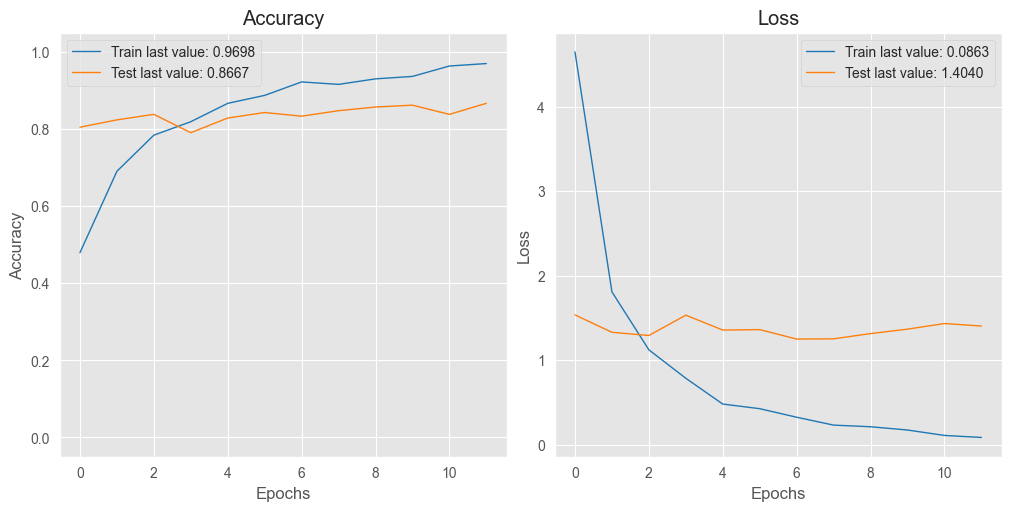

In [62]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

# Display the training and validation history for accuracy and loss over epochs
show_history(history3)

# Save the training history plot to a file called 'standard.png'
plot_history(history3, path="standard.png")

# Close the plot to avoid inline display in environments where it's not needed
plt.close()


## 4.Approche nouvelle par Dataset avec data augmentation intégrée au modèle (model4)

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [63]:
# Afficher les informations
display_dataset_info(dataset_train, "Training dataset")
display_dataset_info(dataset_val, "Validation dataset")
display_dataset_info(dataset_test, "Test dataset")

Found 630 files belonging to 7 classes in Training dataset.
Class 6: 86 files.
Class 5: 87 files.
Class 3: 93 files.
Class 4: 89 files.
Class 2: 96 files.
Class 1: 84 files.
Class 0: 95 files.
Found 210 files belonging to 7 classes in Validation dataset.
Class 4: 31 files.
Class 3: 27 files.
Class 5: 33 files.
Class 6: 34 files.
Class 2: 24 files.
Class 1: 36 files.
Class 0: 25 files.
Found 210 files belonging to 7 classes in Test dataset.
Class 3: 30 files.
Class 5: 30 files.
Class 4: 30 files.
Class 0: 30 files.
Class 6: 30 files.
Class 2: 30 files.
Class 1: 30 files.


In [64]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)  # Conversion de l'image en type float32
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Redimensionnement de l'image à IMG_SIZE x IMG_SIZE
    image = (image / 255.0)  # Normalisation de l'image (mettre les valeurs des pixels entre 0 et 1)
    return image, label

In [65]:
from tensorflow.keras.layers import Input

def create_model_fct2():
    # Data augmentation
    data_augmentation = Sequential([
        Input(shape=(224, 224, 3)),  # Define input shape explicitly
        RandomFlip("horizontal"),  # Randomly flip the image horizontally
        RandomRotation(0.1),  # Randomly rotate the image by up to 10%
        RandomZoom(0.1),  # Randomly zoom the image by up to 10%
    ])
    
    # Load the pre-trained VGG16 model
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    
    # Freeze the pre-trained layers
    for layer in model_base.layers:
        layer.trainable = False

    # Define the new model
    model = Sequential([
        data_augmentation,  # Apply data augmentation to the input
        Rescaling(1./127.5, offset=-1),  # Normalize pixel values to the range [-1, 1]
        model_base,  # Add the pre-trained VGG16 model (feature extractor)
        GlobalAveragePooling2D(),  # Apply global average pooling to reduce dimensionality
        Dense(256, activation='relu'),  # Fully connected layer with 256 units and ReLU activation
        Dropout(0.5),  # Dropout layer to reduce overfitting by randomly setting 50% of the units to 0
        Dense(7, activation='softmax')  # Output layer for 4-class classification using softmax
    ])

    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # Print the model summary to review the structure
    print(model.summary())
    
    return model


In [66]:
import os

# Model creation
with tf.device('/gpu:0'):
    model4 = create_model_fct2()

# Define the path for saving the model weights using os.path.join
model4_save_path = os.path.join("..", "models", "model4_best_weights.keras")  # Using os.path.join to define the save path

# Callback to save the model weights when validation loss improves
checkpoint = ModelCheckpoint(
    model4_save_path,  # Path where the best weights will be saved
    monitor='val_loss',  # Monitor validation loss to decide when to save the model
    verbose=1,  # Verbose output to show when the model is saved
    save_best_only=True,  # Only save the model if it has improved (i.e., lower validation loss)
    mode='min'  # Save the model when the validation loss is minimized
)

# Callback to stop training early when the validation loss doesn't improve after a few epochs
es = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss to decide when to stop
    mode='min',  # We are interested in minimizing the validation loss
    verbose=1,  # Verbose output to show when early stopping occurs
    patience=5  # If the validation loss does not improve for 5 consecutive epochs, stop the training
)

# List of callbacks
callbacks_list = [checkpoint, es]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [67]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [68]:
# Train the model on the GPU
with tf.device('/gpu:0'):  # Ensures that the model is trained on the GPU (if available)
    history4 = model4.fit(
        dataset_train,  # Training dataset
        validation_data=dataset_val,  # Validation dataset
        batch_size=batch_size,  # Size of the mini-batch during training
        epochs=50,  # Train the model for 50 epochs
        callbacks=callbacks_list,  # List of callbacks to save the model and stop training early
        verbose=1  # Print detailed logs of the training process
    )


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1937 - loss: 2.0800
Epoch 1: val_loss improved from inf to 1.35303, saving model to ..\models\model4_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.1972 - loss: 2.0717 - val_accuracy: 0.6905 - val_loss: 1.3530
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4967 - loss: 1.4525
Epoch 2: val_loss improved from 1.35303 to 1.04854, saving model to ..\models\model4_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.4971 - loss: 1.4509 - val_accuracy: 0.7095 - val_loss: 1.0485
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6164 - loss: 1.1998
Epoch 3: val_loss improved from 1.04854 to 0.86393, saving model to ..\models\model4_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.6178 - loss: 1.1970 - val_accuracy: 0.7667 - val_loss: 0.8639
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6927 - loss: 1.0282
Epoch 4: val_l

In [76]:
# Evaluate the model's performance at the last epoch

# Evaluate the model on the training dataset
loss, accuracy = model4.evaluate(dataset_train, verbose=True)  # Calculate loss and accuracy on the training dataset
print("Training Accuracy   : {:.4f}".format(accuracy))  # Print the training accuracy with 4 decimal precision
print()  # Add an empty line for better readability

# Evaluate the model on the validation dataset
loss, accuracy = model4.evaluate(dataset_val, verbose=True)  # Calculate loss and accuracy on the validation dataset
print("Validation Accuracy :  {:.4f}".format(accuracy))  # Print the validation accuracy with 4 decimal precision


20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.8904 - loss: 0.3152
Training Accuracy   : 0.9143

7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.8113 - loss: 0.6241
Validation Accuracy :  0.8143


In [77]:
# Evaluate the model's performance at the best epoch (where the validation performance was highest)

# Load the best weights of the model (saved at the epoch with the lowest validation loss)
model4.load_weights(model4_save_path)

# Evaluate the model on the validation dataset using the best weights
loss, accuracy = model4.evaluate(dataset_val, verbose=False)  # Calculate loss and accuracy on the validation dataset
print("Validation Accuracy :  {:.4f}".format(accuracy))  # Print validation accuracy with 4 decimal precision

# Evaluate the model on the test dataset using the best weights
loss, accuracy = model4.evaluate(dataset_test, verbose=False)  # Calculate loss and accuracy on the test dataset
print("Test Accuracy       :  {:.4f}".format(accuracy))  # Print test accuracy with 4 decimal precision

Validation Accuracy :  0.8286
Test Accuracy       :  0.7619


### Objectif: 
- **Évaluer la performance du modèle** sur les données de test pour vérifier sa capacité à généraliser à de nouvelles images.
- **Comparer les performances** du modèle sur les données de validation et de test pour évaluer sa capacité à généraliser.

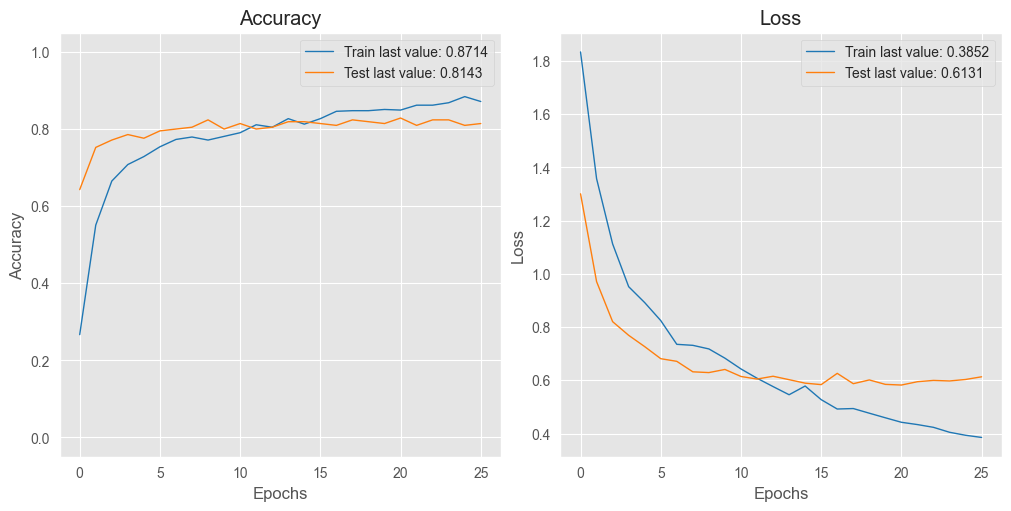

In [78]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

### Observations :
- Les courbes de précision et de perte montrent que le modèle s'améliore au fil des époques, tant sur les données d'entraînement que de validation.
- **Précision :** La précision sur les données d'entraînement et de validation augmente progressivement, atteignant des valeurs élevées.
- **Perte :** La perte diminue régulièrement, indiquant que le modèle apprend efficacement les caractéristiques des données.
- **Surapprentissage :** L'écart entre l'accuracy d'entraînement et de validation reste faible, ce qui suggère que le modèle généralise bien aux nouvelles données. Cependant, pour confirmer l'absence de surapprentissage, il pourrait être pertinent d'entraîner le modèle avec plus de données. Si les performances continuent de s'améliorer avec des données supplémentaires, cela validera encore mieux la généralisation. L'augmentation de la complexité du modèle peut également être envisagée, mais doit être faite avec précaution pour éviter de surapprendre sur les données existantes.
- **Convergence :** La perte se stabilise, indiquant que le modèle a appris les informations principales des données.
- **Performance :** Le modèle atteint une précision élevée sur les données de test, confirmant sa capacité à généraliser à de nouvelles images.


### Voici un récapitulatif des performances pour chacun des modèles :

1. **Modèle 1** :
   - **Validation Accuracy** : 1.0000 (sur le jeu d'entraînement)
   - **Test Accuracy** : 0.8048

2. **Modèle 2** :
   - **Validation Accuracy** : 0.9940
   - **Test Accuracy** : 0.8048

3. **Modèle 3** :
   - **Validation Accuracy** : 0.8190
   - **Test Accuracy** : 0.7571

4. **Modèle 4** :
   - **Validation Accuracy** : 0.8286
   - **Test Accuracy** : 0.7619

### Conclusion :
Le **modèle 2** semble être le meilleur choix car il présente un excellent **Validation Accuracy** de 0.9940 tout en maintenant un **Test Accuracy** élevé à 0.8048. Même si le **modèle 1** a une **Validation Accuracy** parfait, ce résultat pourrait indiquer un surapprentissage étant donné que son **Test Accuracy** n'est pas meilleur que celui du **modèle 2**.

Je enregistre donc le **modèle 2** comme le meilleur modèle à utiliser.